# Clipping vs Sampling in iDP-SGD

## Define Setup


In [87]:
## Load Imports

from opacus_new import PrivacyEngine
from opacus_new.accountants import RDPAccountant
from opacus_new.validators.module_validator import ModuleValidator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models

import numpy as np

from types import SimpleNamespace
from tqdm import tqdm
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Secure RNG turned off.*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [88]:
## Define a custom dataset class

class customSmallDS(Dataset):
    def __init__(self, data, target):
        self.tensors = [data, target]

class CustomDataset(Dataset):
    def __init__(self, num_samples=10_000, height=32, width=32, num_features=3, transform=None, target_transform=None):
        self.data = (255 * np.random.rand(num_samples, height, width, num_features)).astype(np.uint8)
        self.targets = torch.randint(0, 10, (num_samples,))
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = customSmallDS(self.data, self.targets)
        self.indices = list(range(num_samples))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]

        # Apply transformations if any
        if self.transform:
            sample = self.transform(sample)

        if self.target_transform:
            target = self.target_transform(target)

        return sample, target
    
@classmethod
def from_dataset(cls, dataset):
    # If we got a Subset, unwrap it
    if isinstance(dataset, torch.utils.data.Subset):
        data = dataset.dataset.data[dataset.indices]
        targets = dataset.dataset.targets[dataset.indices]
        transform = getattr(dataset.dataset, "transform", None)
        target_transform = getattr(dataset.dataset, "target_transform", None)
    else:
        data = dataset.data
        targets = dataset.targets
        transform = getattr(dataset, "transform", None)
        target_transform = getattr(dataset, "target_transform", None)

    return cls(
        data=data,
        targets=targets,
        transform=transform,
        target_transform=target_transform,
    )

In [89]:
## Define a custom model class

class DummyResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.resnet18(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


In [90]:

def make_private(model, train_loader, pp_budgets, args):
    modulevalidator = ModuleValidator()
    model = modulevalidator.fix_and_validate(model)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    privacy_engine = PrivacyEngine(accountant=args.accountant,
                                   individualize=args.individualize,
                                   weights=args.weights,
                                   pp_budgets=pp_budgets)
    if args.adapt_weights_to_budgets:
        private_model, private_optimizer, private_loader = privacy_engine \
            .make_private_with_epsilon(module=model,
                                       optimizer=optimizer,
                                       data_loader=train_loader,
                                       target_epsilon=min(pp_budgets),
                                       target_delta=args.target_delta,
                                       epochs=args.epochs,
                                       max_grad_norm=args.max_grad_norm,
                                       optimal=True,
                                       max_alpha=10_000)
                                    #    numeric=True)
    else:
        private_model, private_optimizer, private_loader = privacy_engine \
            .make_private(module=model,
                          optimizer=optimizer,
                          data_loader=train_loader,
                          noise_multiplier=args.noise_multiplier,
                          max_grad_norm=args.max_grad_norm)

    if args.individualize == 'clipping':
        print("Maxgradnorm:", privacy_engine.weights)
        print("budgets:", list(np.unique(np.array(pp_budgets), return_counts=True)))
        print("noise_multiplier:", [private_optimizer.noise_multiplier * args.max_grad_norm/priv for priv in privacy_engine.weights])
        print("weights:", privacy_engine.weights)
        print()
        return{
            "budgets": list(np.unique(np.array(pp_budgets))),
            "max_grad_norms": privacy_engine.weights,
            "sample_rate": [1 / len(private_loader)] * len(privacy_engine.weights),
            "noise_multiplier": [private_optimizer.noise_multiplier for priv in privacy_engine.weights] 
        }
    elif args.individualize == 'sampling':
        return{
            "budgets": list(np.unique(np.array(pp_budgets))),
            "max_grad_norms": [args.max_grad_norm] * len(privacy_engine.weights),
            "sample_rate":privacy_engine.weights,
            "noise_multiplier":[private_optimizer.noise_multiplier] * len(privacy_engine.weights)
        }
    else:
        return

In [91]:
def compute_epsilon_delta(noise_multiplier, deltas, iterations, sampling_rate, clipping_norm):
    accountant = RDPAccountant()
    for _ in range(int(iterations)):
        accountant.step(noise_multiplier=noise_multiplier * 1/clipping_norm, sample_rate=sampling_rate)
    epsilons = []
    deltas2 = []
    for delta in deltas:
        epsilon = accountant.get_epsilon(delta)
        epsilons.append(epsilon)
        deltas2.append(delta)
    return epsilons, deltas2

## Define Experiment

In [92]:
args = SimpleNamespace(
    accountant="rdp",  # Options: "rdp", "gdp", etc.
    individualize="sampling", # "sampling",  # Options: None, "clipping", "sampling"
    weights=None,  # Should be a list or None
    adapt_weights_to_budgets=True,  # Whether to adapt weights to budgets
    target_delta=1e-12,  # Default delta value for DP
    epochs=5,  # Number of training epochs
    max_grad_norm=1,  # Clipping norm for DP-SGD
    # noise_multiplier=1.0,  # Noise multiplier for DP
    n_data=50000,  # Number of data points
)
dummy_train_loader = DataLoader(CustomDataset(num_samples=args.n_data), batch_size=128, shuffle=True)
dummy_model = DummyResNet18()

# epsilons_1 = np.linspace(1, 100, 20)
# epsilon_2 = 10S
# portion_size_1 = np.linspace(0.05, 0.95, 19)
# deltas = np.linspace(1e-10, 1-1e-10, 20)

epsilons_1 = np.linspace(4, 16, 30)
epsilon_2 = 8
portion_size_1 = np.linspace(0.1, 0.9, 30)
deltas = np.logspace(-12, -0.001, 1000)


In [93]:
def f_eps_delta(alpha, epsilon, delta):
    """Piecewise linear trade-off function f_{ε, δ} (from pure (ε, δ)-DP)."""
    return np.maximum(
        0,
        np.maximum(
            1 - delta - np.exp(epsilon) * alpha,
            np.exp(-epsilon) * (1 - delta - alpha),
        ),
    )

In [94]:
from collections import defaultdict
from itertools import product
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Worker function (unchanged)
def worker(job):
    eps_1, portion = job

    n_portion = int(portion * args.n_data)
    pp_budgets = [eps_1] * n_portion + [epsilon_2] * (args.n_data - n_portion)

    sampling_data = make_private(dummy_model, dummy_train_loader, pp_budgets, args)

    noise_multipliers = sampling_data["noise_multiplier"]
    sample_rates      = sampling_data["sample_rate"]
    if len(sample_rates) != 2:
        return -1
    if len(noise_multipliers) == 2:
        nm = noise_multipliers[1] if eps_1 <= epsilon_2 else noise_multipliers[0]
        sr = sample_rates[1] if eps_1 <= epsilon_2 else sample_rates[0]
    else:
        nm = noise_multipliers[0]
        sr = sample_rates[0]

    # epsilons, deltas_out = compute_epsilon_delta(
    #     noise_multiplier=nm,
    #     deltas=deltas,
    #     iterations=args.epochs * len(dummy_train_loader),
    #     sampling_rate=sr,
    #     clipping_norm=1,
    # )
    print(f"finished {eps_1}, {portion}")
    return eps_1, portion, nm, sr

# Prepare jobs
jobs = list(product(epsilons_1, portion_size_1))

# Parallel execution
data = defaultdict(dict)
with Pool(processes=24) as pool:
    results = list(tqdm(pool.imap(worker, jobs), total=len(jobs)))
results = [x for x in results if x != -1]

# Collect results
for eps_1, portion, nm, sr in results:
    print(f"{eps_1}  {portion}  {nm} {sr}")
    data[eps_1][portion] = [eps_1, portion, nm, sr]


  0%|          | 0/900 [00:00<?, ?it/s]

finished 4.0, 0.706896551724138
finished 4.0, 0.7344827586206897
finished 4.0, 0.6241379310344828
finished 4.0, 0.6517241379310346
finished 4.0, 0.5965517241379311
finished 4.0, 0.5689655172413793
finished 4.0, 0.5413793103448277
finished 4.0, 0.5137931034482759
finished 4.0, 0.6793103448275862
finished 4.0, 0.403448275862069
finished 4.0, 0.45862068965517244
finished 4.0, 0.4310344827586208
finished 4.0, 0.4862068965517242
finished 4.0, 0.34827586206896555
finished 4.0, 0.2655172413793104
finished 4.0, 0.21034482758620693
finished 4.0, 0.2931034482758621
finished 4.0, 0.23793103448275865
finished 4.0, 0.12758620689655173
finished 4.0, 0.15517241379310345
finished 4.0, 0.1827586206896552
finished 4.0, 0.3758620689655173
finished 4.0, 0.1


  0%|          | 1/900 [01:40<25:11:01, 100.85s/it]

finished 4.0, 0.3206896551724138


  1%|          | 9/900 [01:52<2:01:31,  8.18s/it]  

finished 4.0, 0.8724137931034484
finished 4.0, 0.9
finished 4.0, 0.8448275862068966
finished 4.0, 0.8172413793103449
finished 4.0, 0.7620689655172415


  3%|▎         | 25/900 [03:09<1:30:51,  6.23s/it]

finished 4.0, 0.7896551724137931


  3%|▎         | 26/900 [03:10<1:26:30,  5.94s/it]

finished 4.413793103448276, 0.15517241379310345
finished 4.413793103448276, 0.12758620689655173
finished 4.413793103448276, 0.1


  3%|▎         | 31/900 [03:16<1:04:56,  4.48s/it]

finished 4.413793103448276, 0.4310344827586208
finished 4.413793103448276, 0.403448275862069
finished 4.413793103448276, 0.4862068965517242
finished 4.413793103448276, 0.21034482758620693
finished 4.413793103448276, 0.1827586206896552


  4%|▍         | 34/900 [03:17<52:15,  3.62s/it]  

finished 4.413793103448276, 0.45862068965517244
finished 4.413793103448276, 0.23793103448275865


  4%|▍         | 36/900 [03:17<43:43,  3.04s/it]

finished 4.413793103448276, 0.3758620689655173
finished 4.413793103448276, 0.5137931034482759
finished 4.413793103448276, 0.5413793103448277
finished 4.413793103448276, 0.2931034482758621
finished 4.413793103448276, 0.3206896551724138
finished 4.413793103448276, 0.5689655172413793
finished 4.413793103448276, 0.2655172413793104


  4%|▍         | 37/900 [03:19<42:05,  2.93s/it]

finished 4.413793103448276, 0.34827586206896555


  4%|▍         | 40/900 [03:19<29:34,  2.06s/it]

finished 4.413793103448276, 0.5965517241379311


  5%|▌         | 49/900 [04:39<1:24:42,  5.97s/it]

finished 4.413793103448276, 0.6517241379310346
finished 4.413793103448276, 0.6793103448275862
finished 4.413793103448276, 0.9
finished 4.413793103448276, 0.6241379310344828


  6%|▌         | 50/900 [04:41<1:19:29,  5.61s/it]

finished 4.413793103448276, 0.706896551724138


  6%|▌         | 53/900 [04:44<1:02:35,  4.43s/it]

finished 4.413793103448276, 0.7344827586206897


  6%|▌         | 54/900 [04:46<58:11,  4.13s/it]  

finished 4.413793103448276, 0.7620689655172415


  6%|▌         | 55/900 [04:51<59:05,  4.20s/it]

finished 4.413793103448276, 0.7896551724137931


  6%|▌         | 56/900 [04:52<51:22,  3.65s/it]

finished 4.413793103448276, 0.8172413793103449


  6%|▋         | 57/900 [04:52<42:03,  2.99s/it]

finished 4.413793103448276, 0.8724137931034484
finished 4.413793103448276, 0.8448275862068966


  6%|▋         | 58/900 [04:52<33:35,  2.39s/it]

finished 4.827586206896552, 0.21034482758620693
finished 4.827586206896552, 0.1827586206896552
finished 4.827586206896552, 0.1


  7%|▋         | 61/900 [04:55<25:14,  1.81s/it]

finished 4.827586206896552, 0.15517241379310345
finished 4.827586206896552, 0.12758620689655173


  7%|▋         | 62/900 [04:56<21:42,  1.55s/it]

finished 4.827586206896552, 0.2931034482758621
finished 4.827586206896552, 0.23793103448275865


  7%|▋         | 66/900 [04:57<12:22,  1.12it/s]

finished 4.827586206896552, 0.2655172413793104


  7%|▋         | 67/900 [04:57<10:48,  1.29it/s]

finished 4.827586206896552, 0.3206896551724138


  8%|▊         | 69/900 [04:57<07:56,  1.74it/s]

finished 4.827586206896552, 0.34827586206896555


  8%|▊         | 70/900 [04:58<07:10,  1.93it/s]

finished 4.827586206896552, 0.403448275862069
finished 4.827586206896552, 0.3758620689655173


  8%|▊         | 71/900 [04:59<10:20,  1.34it/s]

finished 4.827586206896552, 0.45862068965517244
finished 4.827586206896552, 0.5137931034482759
finished 4.827586206896552, 0.4310344827586208


  8%|▊         | 73/900 [06:18<3:25:20, 14.90s/it]

finished 4.827586206896552, 0.5413793103448277
finished 4.827586206896552, 0.4862068965517242


  8%|▊         | 75/900 [06:19<2:17:55, 10.03s/it]

finished 4.827586206896552, 0.5689655172413793


  9%|▊         | 78/900 [06:21<1:21:51,  5.97s/it]

finished 4.827586206896552, 0.5965517241379311


  9%|▉         | 79/900 [06:23<1:14:30,  5.44s/it]

finished 4.827586206896552, 0.6241379310344828


  9%|▉         | 80/900 [06:26<1:07:53,  4.97s/it]

finished 4.827586206896552, 0.706896551724138
finished 4.827586206896552, 0.6517241379310346


  9%|▉         | 81/900 [06:27<54:33,  4.00s/it]  

finished 4.827586206896552, 0.6793103448275862


  9%|▉         | 82/900 [06:27<42:39,  3.13s/it]

finished 4.827586206896552, 0.7344827586206897


  9%|▉         | 84/900 [06:28<27:24,  2.01s/it]

finished 4.827586206896552, 0.8724137931034484
finished 4.827586206896552, 0.7620689655172415


  9%|▉         | 85/900 [06:31<30:04,  2.21s/it]

finished 4.827586206896552, 0.8448275862068966
finished 4.827586206896552, 0.8172413793103449
finished 4.827586206896552, 0.7896551724137931


 10%|▉         | 86/900 [06:31<24:11,  1.78s/it]

finished 4.827586206896552, 0.9


 10%|█         | 90/900 [06:32<10:48,  1.25it/s]

finished 5.241379310344827, 0.1


 10%|█         | 91/900 [06:35<16:36,  1.23s/it]

finished 5.241379310344827, 0.15517241379310345
finished 5.241379310344827, 0.12758620689655173


 10%|█         | 92/900 [06:36<17:26,  1.30s/it]

finished 5.241379310344827, 0.1827586206896552


 10%|█         | 94/900 [06:37<11:58,  1.12it/s]

finished 5.241379310344827, 0.21034482758620693


 11%|█         | 95/900 [06:38<12:23,  1.08it/s]

finished 5.241379310344827, 0.23793103448275865


 11%|█         | 96/900 [06:39<12:23,  1.08it/s]

finished 5.241379310344827, 0.2655172413793104


 11%|█         | 97/900 [07:55<4:17:53, 19.27s/it]

finished 5.241379310344827, 0.34827586206896555
finished 5.241379310344827, 0.2931034482758621


 11%|█         | 98/900 [07:55<3:12:40, 14.41s/it]

finished 5.241379310344827, 0.3206896551724138
finished 5.241379310344827, 0.3758620689655173


 11%|█         | 101/900 [07:57<1:34:31,  7.10s/it]

finished 5.241379310344827, 0.403448275862069


 11%|█▏        | 102/900 [07:57<1:16:26,  5.75s/it]

finished 5.241379310344827, 0.4310344827586208


 11%|█▏        | 103/900 [08:00<1:08:54,  5.19s/it]

finished 5.241379310344827, 0.45862068965517244


 12%|█▏        | 104/900 [08:03<59:28,  4.48s/it]  

finished 5.241379310344827, 0.5137931034482759
finished 5.241379310344827, 0.4862068965517242


 12%|█▏        | 105/900 [08:04<47:31,  3.59s/it]

finished 5.241379310344827, 0.5413793103448277
finished 5.241379310344827, 0.5689655172413793


 12%|█▏        | 108/900 [08:05<24:36,  1.86s/it]

finished 5.241379310344827, 0.5965517241379311


 12%|█▏        | 109/900 [08:06<23:48,  1.81s/it]

finished 5.241379310344827, 0.7896551724137931
finished 5.241379310344827, 0.706896551724138
finished 5.241379310344827, 0.7344827586206897
finished 5.241379310344827, 0.6793103448275862
finished 5.241379310344827, 0.6241379310344828


 12%|█▏        | 110/900 [08:07<21:11,  1.61s/it]

finished 5.241379310344827, 0.6517241379310346


 12%|█▏        | 111/900 [08:08<18:34,  1.41s/it]

finished 5.241379310344827, 0.8448275862068966
finished 5.241379310344827, 0.8172413793103449
finished 5.241379310344827, 0.7620689655172415


 13%|█▎        | 115/900 [08:10<11:03,  1.18it/s]

finished 5.241379310344827, 0.8724137931034484


 13%|█▎        | 119/900 [08:10<06:52,  1.89it/s]

finished 5.241379310344827, 0.9


 13%|█▎        | 120/900 [08:12<08:28,  1.53it/s]

finished 5.655172413793103, 0.12758620689655173
finished 5.655172413793103, 0.1827586206896552
finished 5.655172413793103, 0.1


 13%|█▎        | 121/900 [09:32<3:00:26, 13.90s/it]

finished 5.655172413793103, 0.15517241379310345


 14%|█▎        | 123/900 [09:33<2:04:04,  9.58s/it]

finished 5.655172413793103, 0.23793103448275865
finished 5.655172413793103, 0.21034482758620693


 14%|█▍        | 125/900 [09:34<1:27:02,  6.74s/it]

finished 5.655172413793103, 0.2655172413793104


 14%|█▍        | 127/900 [09:38<1:06:42,  5.18s/it]

finished 5.655172413793103, 0.2931034482758621


 14%|█▍        | 128/900 [09:39<58:20,  4.53s/it]  

finished 5.655172413793103, 0.403448275862069
finished 5.655172413793103, 0.3758620689655173
finished 5.655172413793103, 0.34827586206896555
finished 5.655172413793103, 0.6793103448275862
finished 5.655172413793103, 0.3206896551724138


 14%|█▍        | 129/900 [09:42<53:46,  4.19s/it]

finished 5.655172413793103, 0.706896551724138
finished 5.655172413793103, 0.5689655172413793
finished 5.655172413793103, 0.45862068965517244
finished 5.655172413793103, 0.5413793103448277
finished 5.655172413793103, 0.4310344827586208


 15%|█▍        | 133/900 [09:44<27:48,  2.18s/it]

finished 5.655172413793103, 0.5137931034482759
finished 5.655172413793103, 0.5965517241379311
finished 5.655172413793103, 0.6517241379310346
finished 5.655172413793103, 0.7344827586206897
finished 5.655172413793103, 0.6241379310344828
finished 5.655172413793103, 0.4862068965517242


 15%|█▌        | 135/900 [09:45<21:25,  1.68s/it]

finished 5.655172413793103, 0.8724137931034484
finished 5.655172413793103, 0.9
finished 5.655172413793103, 0.7620689655172415


 16%|█▌        | 145/900 [11:03<1:12:49,  5.79s/it]

finished 5.655172413793103, 0.7896551724137931


 16%|█▌        | 146/900 [11:04<1:06:56,  5.33s/it]

finished 5.655172413793103, 0.8172413793103449
finished 5.655172413793103, 0.8448275862068966


 16%|█▋        | 148/900 [11:05<55:01,  4.39s/it]  

finished 6.068965517241379, 0.1


 17%|█▋        | 151/900 [11:16<52:28,  4.20s/it]

finished 6.068965517241379, 0.12758620689655173
finished 6.068965517241379, 0.15517241379310345


 17%|█▋        | 153/900 [11:18<43:22,  3.48s/it]

finished 6.068965517241379, 0.21034482758620693
finished 6.068965517241379, 0.1827586206896552


 17%|█▋        | 154/900 [11:19<38:53,  3.13s/it]

finished 6.068965517241379, 0.23793103448275865


 17%|█▋        | 156/900 [11:20<29:02,  2.34s/it]

finished 6.068965517241379, 0.2655172413793104


 17%|█▋        | 157/900 [11:20<24:25,  1.97s/it]

finished 6.068965517241379, 0.34827586206896555
finished 6.068965517241379, 0.4310344827586208
finished 6.068965517241379, 0.3758620689655173
finished 6.068965517241379, 0.403448275862069
finished 6.068965517241379, 0.45862068965517244
finished 6.068965517241379, 0.3206896551724138
finished 6.068965517241379, 0.2931034482758621


 18%|█▊        | 158/900 [11:22<26:05,  2.11s/it]

finished 6.068965517241379, 0.5689655172413793
finished 6.068965517241379, 0.4862068965517242


 18%|█▊        | 165/900 [11:23<09:10,  1.34it/s]

finished 6.068965517241379, 0.5413793103448277
finished 6.068965517241379, 0.5137931034482759


 18%|█▊        | 166/900 [11:23<08:50,  1.38it/s]

finished 6.068965517241379, 0.5965517241379311


 19%|█▉        | 169/900 [12:33<1:41:19,  8.32s/it]

finished 6.068965517241379, 0.706896551724138
finished 6.068965517241379, 0.6793103448275862
finished 6.068965517241379, 0.6241379310344828


 19%|█▉        | 170/900 [12:35<1:30:01,  7.40s/it]

finished 6.068965517241379, 0.6517241379310346


 19%|█▉        | 171/900 [12:35<1:15:33,  6.22s/it]

finished 6.068965517241379, 0.7344827586206897


 19%|█▉        | 174/900 [12:36<46:30,  3.84s/it]  

finished 6.068965517241379, 0.7896551724137931
finished 6.068965517241379, 0.7620689655172415


 19%|█▉        | 175/900 [12:48<1:01:24,  5.08s/it]

finished 6.068965517241379, 0.8172413793103449


 20%|█▉        | 177/900 [12:48<42:06,  3.50s/it]  

finished 6.068965517241379, 0.8448275862068966


 20%|█▉        | 178/900 [12:50<37:23,  3.11s/it]

finished 6.068965517241379, 0.8724137931034484


 20%|█▉        | 179/900 [12:50<30:08,  2.51s/it]

finished 6.068965517241379, 0.9


 20%|██        | 180/900 [12:52<28:14,  2.35s/it]

finished 6.482758620689655, 0.1


 20%|██        | 181/900 [12:58<39:02,  3.26s/it]

finished 6.482758620689655, 0.12758620689655173


 20%|██        | 182/900 [12:58<31:30,  2.63s/it]

finished 6.482758620689655, 0.15517241379310345


 20%|██        | 183/900 [12:59<23:49,  1.99s/it]

finished 6.482758620689655, 0.21034482758620693
finished 6.482758620689655, 0.1827586206896552


 20%|██        | 184/900 [12:59<17:33,  1.47s/it]

finished 6.482758620689655, 0.2931034482758621
finished 6.482758620689655, 0.3206896551724138
finished 6.482758620689655, 0.34827586206896555
finished 6.482758620689655, 0.23793103448275865


 21%|██        | 186/900 [12:59<11:10,  1.06it/s]

finished 6.482758620689655, 0.2655172413793104


 21%|██        | 187/900 [13:00<10:39,  1.12it/s]

finished 6.482758620689655, 0.3758620689655173


 21%|██        | 191/900 [13:01<05:43,  2.07it/s]

finished 6.482758620689655, 0.403448275862069


 21%|██▏       | 192/900 [13:01<05:50,  2.02it/s]

finished 6.482758620689655, 0.5413793103448277
finished 6.482758620689655, 0.5137931034482759
finished 6.482758620689655, 0.5689655172413793
finished 6.482758620689655, 0.45862068965517244
finished 6.482758620689655, 0.4862068965517242
finished 6.482758620689655, 0.4310344827586208


 21%|██▏       | 193/900 [14:12<2:47:52, 14.25s/it]

finished 6.482758620689655, 0.5965517241379311


 22%|██▏       | 199/900 [14:18<1:09:13,  5.92s/it]

finished 6.482758620689655, 0.6517241379310346
finished 6.482758620689655, 0.6241379310344828


 22%|██▏       | 200/900 [14:20<1:03:30,  5.44s/it]

finished 6.482758620689655, 0.6793103448275862


 22%|██▏       | 202/900 [14:21<47:26,  4.08s/it]  

finished 6.482758620689655, 0.706896551724138


 23%|██▎       | 203/900 [14:22<41:15,  3.55s/it]

finished 6.482758620689655, 0.7344827586206897


 23%|██▎       | 204/900 [14:24<38:46,  3.34s/it]

finished 6.482758620689655, 0.9
finished 6.482758620689655, 0.8724137931034484
finished 6.482758620689655, 0.8448275862068966
finished 6.482758620689655, 0.7896551724137931
finished 6.482758620689655, 0.7620689655172415


 23%|██▎       | 205/900 [14:29<43:40,  3.77s/it]

finished 6.482758620689655, 0.8172413793103449


 23%|██▎       | 207/900 [14:30<27:43,  2.40s/it]

finished 6.896551724137931, 0.15517241379310345
finished 6.896551724137931, 0.12758620689655173
finished 6.896551724137931, 0.1827586206896552
finished 6.896551724137931, 0.1


 23%|██▎       | 211/900 [14:38<25:30,  2.22s/it]

finished 6.896551724137931, 0.21034482758620693


 24%|██▍       | 215/900 [14:39<15:33,  1.36s/it]

finished 6.896551724137931, 0.23793103448275865


 24%|██▍       | 216/900 [14:40<14:48,  1.30s/it]

finished 6.896551724137931, 0.2655172413793104


 24%|██▍       | 217/900 [15:43<2:06:09, 11.08s/it]

finished 6.896551724137931, 0.2931034482758621


 24%|██▍       | 218/900 [15:43<1:44:24,  9.18s/it]

finished 6.896551724137931, 0.3206896551724138


 24%|██▍       | 219/900 [15:46<1:28:17,  7.78s/it]

finished 6.896551724137931, 0.3758620689655173
finished 6.896551724137931, 0.34827586206896555


 24%|██▍       | 220/900 [15:46<1:08:21,  6.03s/it]

finished 6.896551724137931, 0.403448275862069


 25%|██▍       | 222/900 [15:47<43:50,  3.88s/it]  

finished 6.896551724137931, 0.5137931034482759
finished 6.896551724137931, 0.4310344827586208


 25%|██▍       | 223/900 [15:53<48:10,  4.27s/it]

finished 6.896551724137931, 0.45862068965517244


 25%|██▍       | 224/900 [15:53<37:15,  3.31s/it]

finished 6.896551724137931, 0.4862068965517242


 25%|██▌       | 225/900 [15:54<29:14,  2.60s/it]

finished 6.896551724137931, 0.5413793103448277


 25%|██▌       | 227/900 [15:54<17:40,  1.58s/it]

finished 6.896551724137931, 0.5689655172413793


 25%|██▌       | 228/900 [15:57<21:09,  1.89s/it]

finished 6.896551724137931, 0.6241379310344828
finished 6.896551724137931, 0.7344827586206897
finished 6.896551724137931, 0.5965517241379311


 25%|██▌       | 229/900 [15:58<19:52,  1.78s/it]

finished 6.896551724137931, 0.6517241379310346


 26%|██▌       | 231/900 [15:59<12:04,  1.08s/it]

finished 6.896551724137931, 0.6793103448275862


 26%|██▌       | 232/900 [16:01<15:27,  1.39s/it]

finished 6.896551724137931, 0.706896551724138


 26%|██▌       | 233/900 [16:02<14:13,  1.28s/it]

finished 6.896551724137931, 0.7620689655172415


 26%|██▌       | 235/900 [16:04<13:25,  1.21s/it]

finished 6.896551724137931, 0.8172413793103449
finished 6.896551724137931, 0.8448275862068966
finished 6.896551724137931, 0.7896551724137931


 26%|██▌       | 236/900 [16:07<17:28,  1.58s/it]

finished 6.896551724137931, 0.8724137931034484


 27%|██▋       | 239/900 [16:08<10:15,  1.07it/s]

finished 6.896551724137931, 0.9


 27%|██▋       | 240/900 [16:09<09:42,  1.13it/s]

finished 7.310344827586206, 0.1


 27%|██▋       | 241/900 [17:21<2:57:35, 16.17s/it]

finished 7.310344827586206, 0.21034482758620693
finished 7.310344827586206, 0.12758620689655173


 27%|██▋       | 242/900 [17:24<2:22:57, 13.04s/it]

finished 7.310344827586206, 0.15517241379310345
finished 7.310344827586206, 0.23793103448275865
finished 7.310344827586206, 0.1827586206896552


 27%|██▋       | 244/900 [17:24<1:26:27,  7.91s/it]

finished 7.310344827586206, 0.2655172413793104


 27%|██▋       | 247/900 [17:28<52:34,  4.83s/it]  

finished 7.310344827586206, 0.2931034482758621


 28%|██▊       | 248/900 [17:29<44:55,  4.13s/it]

finished 7.310344827586206, 0.3206896551724138


 28%|██▊       | 249/900 [17:29<36:44,  3.39s/it]

finished 7.310344827586206, 0.45862068965517244
finished 7.310344827586206, 0.34827586206896555


 28%|██▊       | 250/900 [17:31<31:28,  2.91s/it]

finished 7.310344827586206, 0.5137931034482759
finished 7.310344827586206, 0.3758620689655173


 28%|██▊       | 251/900 [17:31<24:02,  2.22s/it]

finished 7.310344827586206, 0.4310344827586208
finished 7.310344827586206, 0.4862068965517242
finished 7.310344827586206, 0.5413793103448277
finished 7.310344827586206, 0.403448275862069


 28%|██▊       | 252/900 [17:33<25:06,  2.32s/it]

finished 7.310344827586206, 0.5689655172413793


 29%|██▊       | 258/900 [17:34<08:17,  1.29it/s]

finished 7.310344827586206, 0.6517241379310346
finished 7.310344827586206, 0.6793103448275862
finished 7.310344827586206, 0.5965517241379311


 29%|██▉       | 259/900 [17:36<10:08,  1.05it/s]

finished 7.310344827586206, 0.706896551724138
finished 7.310344827586206, 0.6241379310344828


 29%|██▉       | 260/900 [17:38<12:25,  1.17s/it]

finished 7.310344827586206, 0.7344827586206897
finished 7.310344827586206, 0.9
finished 7.310344827586206, 0.8724137931034484
finished 7.310344827586206, 0.7620689655172415


 29%|██▉       | 265/900 [18:49<1:27:58,  8.31s/it]

finished 7.310344827586206, 0.7896551724137931


 30%|██▉       | 266/900 [18:50<1:17:25,  7.33s/it]

finished 7.310344827586206, 0.8172413793103449


 30%|██▉       | 267/900 [18:52<1:08:15,  6.47s/it]

finished 7.310344827586206, 0.8448275862068966


 30%|██▉       | 268/900 [18:53<55:40,  5.29s/it]  

finished 7.724137931034482, 0.12758620689655173
finished 7.724137931034482, 0.1


 30%|███       | 271/900 [19:06<51:50,  4.94s/it]

finished 7.724137931034482, 0.15517241379310345


 30%|███       | 273/900 [19:06<36:43,  3.51s/it]

finished 7.724137931034482, 0.403448275862069
finished 7.724137931034482, 0.4862068965517242
finished 7.724137931034482, 0.4310344827586208
finished 7.724137931034482, 0.2655172413793104
finished 7.724137931034482, 0.1827586206896552


 30%|███       | 274/900 [19:09<34:26,  3.30s/it]

finished 7.724137931034482, 0.23793103448275865
finished 7.724137931034482, 0.2931034482758621
finished 7.724137931034482, 0.45862068965517244
finished 7.724137931034482, 0.21034482758620693


 31%|███       | 275/900 [19:09<28:39,  2.75s/it]

finished 7.724137931034482, 0.3206896551724138


 31%|███       | 279/900 [19:10<13:42,  1.32s/it]

finished 7.724137931034482, 0.34827586206896555


 31%|███       | 280/900 [19:10<11:46,  1.14s/it]

finished 7.724137931034482, 0.5137931034482759
finished 7.724137931034482, 0.3758620689655173


 31%|███       | 281/900 [19:11<11:33,  1.12s/it]

finished 7.724137931034482, 0.5413793103448277


 32%|███▏      | 287/900 [19:11<04:37,  2.21it/s]

finished 7.724137931034482, 0.5689655172413793


 32%|███▏      | 287/900 [19:22<04:37,  2.21it/s]

finished 7.724137931034482, 0.5965517241379311


 32%|███▏      | 289/900 [20:15<1:16:49,  7.54s/it]

finished 7.724137931034482, 0.6241379310344828


 32%|███▏      | 290/900 [20:15<1:06:47,  6.57s/it]

finished 7.724137931034482, 0.6517241379310346


 32%|███▏      | 291/900 [20:17<59:09,  5.83s/it]  

finished 7.724137931034482, 0.6793103448275862


 32%|███▏      | 292/900 [20:18<48:38,  4.80s/it]

finished 7.724137931034482, 0.706896551724138


 33%|███▎      | 293/900 [20:21<44:25,  4.39s/it]

finished 7.724137931034482, 0.7344827586206897


 33%|███▎      | 294/900 [20:21<35:35,  3.52s/it]

finished 7.724137931034482, 0.9
finished 7.724137931034482, 0.7620689655172415


 33%|███▎      | 295/900 [20:29<46:32,  4.62s/it]

finished 7.724137931034482, 0.8172413793103449
finished 7.724137931034482, 0.7896551724137931


 33%|███▎      | 296/900 [20:30<35:43,  3.55s/it]

finished 7.724137931034482, 0.8448275862068966


 33%|███▎      | 298/900 [20:31<23:30,  2.34s/it]

finished 7.724137931034482, 0.8724137931034484


 33%|███▎      | 299/900 [20:32<18:55,  1.89s/it]

finished 8.137931034482758, 0.1


 33%|███▎      | 301/900 [20:42<32:10,  3.22s/it]

finished 8.137931034482758, 0.12758620689655173


 34%|███▎      | 302/900 [20:43<26:17,  2.64s/it]

finished 8.137931034482758, 0.15517241379310345


 34%|███▎      | 303/900 [20:43<20:33,  2.07s/it]

finished 8.137931034482758, 0.21034482758620693finished 8.137931034482758, 0.1827586206896552
finished 8.137931034482758, 0.2655172413793104

finished 8.137931034482758, 0.23793103448275865


 34%|███▍      | 306/900 [20:43<10:30,  1.06s/it]

finished 8.137931034482758, 0.2931034482758621


 34%|███▍      | 308/900 [20:44<08:28,  1.16it/s]

finished 8.137931034482758, 0.3758620689655173
finished 8.137931034482758, 0.34827586206896555
finished 8.137931034482758, 0.3206896551724138


 34%|███▍      | 309/900 [20:45<09:18,  1.06it/s]

finished 8.137931034482758, 0.403448275862069


 35%|███▍      | 312/900 [20:46<06:26,  1.52it/s]

finished 8.137931034482758, 0.4310344827586208


 35%|███▍      | 313/900 [21:48<1:51:29, 11.40s/it]

finished 8.137931034482758, 0.45862068965517244


 35%|███▍      | 314/900 [21:50<1:31:46,  9.40s/it]

finished 8.137931034482758, 0.4862068965517242


 35%|███▌      | 315/900 [21:50<1:13:08,  7.50s/it]

finished 8.137931034482758, 0.5137931034482759


 35%|███▌      | 316/900 [21:51<57:31,  5.91s/it]  

finished 8.137931034482758, 0.5689655172413793
finished 8.137931034482758, 0.5413793103448277


 35%|███▌      | 317/900 [21:56<53:23,  5.49s/it]

finished 8.137931034482758, 0.5965517241379311


 35%|███▌      | 319/900 [22:01<40:58,  4.23s/it]

finished 8.137931034482758, 0.6241379310344828


 36%|███▌      | 320/900 [22:02<35:17,  3.65s/it]

finished 8.137931034482758, 0.6517241379310346


 36%|███▌      | 321/900 [22:07<38:06,  3.95s/it]

finished 8.137931034482758, 0.6793103448275862


 36%|███▌      | 322/900 [22:08<29:10,  3.03s/it]

finished 8.137931034482758, 0.706896551724138


 36%|███▌      | 323/900 [22:09<24:24,  2.54s/it]

finished 8.137931034482758, 0.7344827586206897


 36%|███▌      | 324/900 [22:09<19:12,  2.00s/it]

finished 8.551724137931036, 0.12758620689655173
finished 8.551724137931036, 0.1
finished 8.551724137931036, 0.15517241379310345
finished 8.551724137931036, 0.1827586206896552
finished 8.137931034482758, 0.7620689655172415


 36%|███▌      | 325/900 [22:19<39:58,  4.17s/it]

finished 8.551724137931036, 0.21034482758620693
finished 8.137931034482758, 0.8448275862068966
finished 8.137931034482758, 0.8172413793103449
finished 8.137931034482758, 0.7896551724137931


 36%|███▌      | 326/900 [22:21<32:31,  3.40s/it]

finished 8.137931034482758, 0.9
finished 8.551724137931036, 0.23793103448275865
finished 8.137931034482758, 0.8724137931034484


 37%|███▋      | 329/900 [22:22<16:44,  1.76s/it]

finished 8.551724137931036, 0.2655172413793104


 37%|███▋      | 337/900 [23:21<52:42,  5.62s/it]

finished 8.551724137931036, 0.2931034482758621


 38%|███▊      | 338/900 [23:23<48:50,  5.21s/it]

finished 8.551724137931036, 0.3206896551724138


 38%|███▊      | 339/900 [23:24<43:05,  4.61s/it]

finished 8.551724137931036, 0.34827586206896555


 38%|███▊      | 340/900 [23:25<37:49,  4.05s/it]

finished 8.551724137931036, 0.3758620689655173


 38%|███▊      | 341/900 [23:30<38:25,  4.12s/it]

finished 8.551724137931036, 0.403448275862069


 38%|███▊      | 342/900 [23:31<33:30,  3.60s/it]

finished 8.551724137931036, 0.4310344827586208


 38%|███▊      | 343/900 [23:34<31:48,  3.43s/it]

finished 8.551724137931036, 0.45862068965517244


 38%|███▊      | 344/900 [23:35<26:00,  2.81s/it]

finished 8.551724137931036, 0.4862068965517242


 38%|███▊      | 345/900 [23:42<35:04,  3.79s/it]

finished 8.551724137931036, 0.5137931034482759


 38%|███▊      | 346/900 [23:42<26:37,  2.88s/it]

finished 8.551724137931036, 0.5413793103448277


 39%|███▊      | 347/900 [23:42<20:11,  2.19s/it]

finished 8.551724137931036, 0.5689655172413793


 39%|███▊      | 348/900 [23:44<17:39,  1.92s/it]

finished 8.551724137931036, 0.5965517241379311


 39%|███▉      | 349/900 [23:51<32:40,  3.56s/it]

finished 8.551724137931036, 0.6241379310344828


 39%|███▉      | 350/900 [23:52<25:01,  2.73s/it]

finished 8.551724137931036, 0.6517241379310346


 39%|███▉      | 351/900 [23:55<26:42,  2.92s/it]

finished 8.551724137931036, 0.6793103448275862


 39%|███▉      | 352/900 [23:57<21:53,  2.40s/it]

finished 8.551724137931036, 0.706896551724138


 39%|███▉      | 353/900 [23:57<16:03,  1.76s/it]

finished 8.551724137931036, 0.7620689655172415
finished 8.551724137931036, 0.7896551724137931
finished 8.551724137931036, 0.7344827586206897


 39%|███▉      | 354/900 [23:58<15:23,  1.69s/it]

finished 8.551724137931036, 0.8172413793103449


 40%|███▉      | 357/900 [23:59<07:37,  1.19it/s]

finished 8.551724137931036, 0.8448275862068966
finished 8.551724137931036, 0.9
finished 8.551724137931036, 0.8724137931034484


 40%|███▉      | 359/900 [24:01<07:34,  1.19it/s]

finished 8.96551724137931, 0.1


 40%|████      | 361/900 [24:54<1:25:26,  9.51s/it]

finished 8.96551724137931, 0.12758620689655173


 40%|████      | 362/900 [24:57<1:12:56,  8.13s/it]

finished 8.96551724137931, 0.15517241379310345


 40%|████      | 363/900 [24:57<58:22,  6.52s/it]  

finished 8.96551724137931, 0.1827586206896552


 40%|████      | 364/900 [24:58<46:54,  5.25s/it]

finished 8.96551724137931, 0.21034482758620693


 41%|████      | 365/900 [25:05<49:18,  5.53s/it]

finished 8.96551724137931, 0.23793103448275865


 41%|████      | 366/900 [25:07<40:50,  4.59s/it]

finished 8.96551724137931, 0.2931034482758621
finished 8.96551724137931, 0.2655172413793104


 41%|████      | 367/900 [25:08<33:34,  3.78s/it]

finished 8.96551724137931, 0.3758620689655173
finished 8.96551724137931, 0.3206896551724138


 41%|████      | 369/900 [25:17<34:56,  3.95s/it]

finished 8.96551724137931, 0.34827586206896555


 41%|████      | 370/900 [25:17<27:12,  3.08s/it]

finished 8.96551724137931, 0.403448275862069


 41%|████▏     | 372/900 [25:19<18:44,  2.13s/it]

finished 8.96551724137931, 0.4310344827586208


 41%|████▏     | 373/900 [25:26<29:11,  3.32s/it]

finished 8.96551724137931, 0.45862068965517244
finished 8.96551724137931, 0.4862068965517242


 42%|████▏     | 375/900 [25:30<24:18,  2.78s/it]

finished 8.96551724137931, 0.5413793103448277
finished 8.96551724137931, 0.5137931034482759


 42%|████▏     | 376/900 [25:32<22:13,  2.54s/it]

finished 8.96551724137931, 0.5689655172413793


 42%|████▏     | 378/900 [25:32<14:05,  1.62s/it]

finished 8.96551724137931, 0.5965517241379311


 42%|████▏     | 379/900 [25:33<12:46,  1.47s/it]

finished 8.96551724137931, 0.6241379310344828


 42%|████▏     | 380/900 [25:34<11:40,  1.35s/it]

finished 8.96551724137931, 0.6793103448275862
finished 8.96551724137931, 0.6517241379310346


 42%|████▏     | 381/900 [25:38<17:36,  2.04s/it]

finished 8.96551724137931, 0.706896551724138


 43%|████▎     | 383/900 [25:39<11:39,  1.35s/it]

finished 8.96551724137931, 0.7344827586206897


 43%|████▎     | 384/900 [25:40<11:05,  1.29s/it]

finished 8.96551724137931, 0.7620689655172415


 43%|████▎     | 385/900 [26:31<1:58:17, 13.78s/it]

finished 8.96551724137931, 0.7896551724137931


 43%|████▎     | 386/900 [26:34<1:33:36, 10.93s/it]

finished 8.96551724137931, 0.8172413793103449


 43%|████▎     | 387/900 [26:35<1:09:17,  8.10s/it]

finished 8.96551724137931, 0.8448275862068966


 43%|████▎     | 388/900 [26:36<51:34,  6.04s/it]  

finished 9.379310344827587, 0.1
finished 9.379310344827587, 0.12758620689655173
finished 8.96551724137931, 0.8724137931034484


 43%|████▎     | 389/900 [26:43<55:00,  6.46s/it]

finished 8.96551724137931, 0.9


 43%|████▎     | 390/900 [26:46<45:10,  5.31s/it]

finished 9.379310344827587, 0.15517241379310345


 44%|████▎     | 393/900 [26:51<27:49,  3.29s/it]

finished 9.379310344827587, 0.21034482758620693
finished 9.379310344827587, 0.23793103448275865
finished 9.379310344827587, 0.1827586206896552


 44%|████▍     | 394/900 [26:52<25:12,  2.99s/it]

finished 9.379310344827587, 0.2655172413793104


 44%|████▍     | 397/900 [27:00<22:44,  2.71s/it]

finished 9.379310344827587, 0.2931034482758621


 44%|████▍     | 398/900 [27:00<19:45,  2.36s/it]

finished 9.379310344827587, 0.3206896551724138


 44%|████▍     | 399/900 [27:04<22:18,  2.67s/it]

finished 9.379310344827587, 0.34827586206896555


 44%|████▍     | 400/900 [27:05<17:34,  2.11s/it]

finished 9.379310344827587, 0.403448275862069
finished 9.379310344827587, 0.3758620689655173


 45%|████▍     | 401/900 [27:06<16:48,  2.02s/it]

finished 9.379310344827587, 0.4310344827586208


 45%|████▍     | 403/900 [27:07<11:26,  1.38s/it]

finished 9.379310344827587, 0.45862068965517244


 45%|████▍     | 404/900 [27:08<11:11,  1.35s/it]

finished 9.379310344827587, 0.4862068965517242


 45%|████▌     | 405/900 [27:10<12:04,  1.46s/it]

finished 9.379310344827587, 0.5137931034482759


 45%|████▌     | 406/900 [27:12<12:53,  1.57s/it]

finished 9.379310344827587, 0.5413793103448277


 45%|████▌     | 407/900 [27:13<10:43,  1.30s/it]

finished 9.379310344827587, 0.5689655172413793


 45%|████▌     | 408/900 [27:15<12:39,  1.54s/it]

finished 9.379310344827587, 0.5965517241379311


 45%|████▌     | 409/900 [28:05<2:04:43, 15.24s/it]

finished 9.379310344827587, 0.6241379310344828


 46%|████▌     | 410/900 [28:08<1:37:05, 11.89s/it]

finished 9.379310344827587, 0.6517241379310346


 46%|████▌     | 411/900 [28:12<1:18:01,  9.57s/it]

finished 9.379310344827587, 0.6793103448275862


 46%|████▌     | 412/900 [28:13<57:15,  7.04s/it]  

finished 9.379310344827587, 0.706896551724138


 46%|████▌     | 413/900 [28:18<52:56,  6.52s/it]

finished 9.379310344827587, 0.7344827586206897


 46%|████▌     | 414/900 [28:20<40:03,  4.95s/it]

finished 9.379310344827587, 0.7620689655172415


 46%|████▌     | 415/900 [28:22<34:31,  4.27s/it]

finished 9.379310344827587, 0.7896551724137931


 46%|████▌     | 416/900 [28:24<29:06,  3.61s/it]

finished 9.379310344827587, 0.8172413793103449


 46%|████▋     | 417/900 [28:30<32:44,  4.07s/it]

finished 9.379310344827587, 0.8448275862068966


 46%|████▋     | 418/900 [28:31<25:52,  3.22s/it]

finished 9.379310344827587, 0.8724137931034484


 47%|████▋     | 419/900 [28:32<21:27,  2.68s/it]

finished 9.379310344827587, 0.9
finished 9.793103448275861, 0.1


 47%|████▋     | 421/900 [28:33<13:38,  1.71s/it]

finished 9.793103448275861, 0.12758620689655173


 47%|████▋     | 422/900 [28:34<11:42,  1.47s/it]

finished 9.793103448275861, 0.1827586206896552
finished 9.793103448275861, 0.15517241379310345


 47%|████▋     | 423/900 [28:39<19:40,  2.48s/it]

finished 9.793103448275861, 0.21034482758620693


 47%|████▋     | 425/900 [28:40<11:59,  1.51s/it]

finished 9.793103448275861, 0.23793103448275865


 47%|████▋     | 426/900 [28:41<11:20,  1.44s/it]

finished 9.793103448275861, 0.2655172413793104


 47%|████▋     | 427/900 [28:42<10:21,  1.31s/it]

finished 9.793103448275861, 0.2931034482758621


 48%|████▊     | 428/900 [28:44<11:30,  1.46s/it]

finished 9.793103448275861, 0.3206896551724138


 48%|████▊     | 429/900 [28:45<09:49,  1.25s/it]

finished 9.793103448275861, 0.3758620689655173
finished 9.793103448275861, 0.34827586206896555


 48%|████▊     | 430/900 [28:47<13:34,  1.73s/it]

finished 9.793103448275861, 0.403448275862069


 48%|████▊     | 432/900 [28:50<11:41,  1.50s/it]

finished 9.793103448275861, 0.4310344827586208


 48%|████▊     | 433/900 [29:39<1:41:03, 12.98s/it]

finished 9.793103448275861, 0.45862068965517244


 48%|████▊     | 434/900 [29:42<1:21:57, 10.55s/it]

finished 9.793103448275861, 0.4862068965517242


 48%|████▊     | 435/900 [29:46<1:08:02,  8.78s/it]

finished 9.793103448275861, 0.5137931034482759


 48%|████▊     | 436/900 [29:47<51:19,  6.64s/it]  

finished 9.793103448275861, 0.5413793103448277


 49%|████▊     | 437/900 [29:53<49:18,  6.39s/it]

finished 9.793103448275861, 0.5689655172413793


 49%|████▊     | 438/900 [29:54<36:08,  4.69s/it]

finished 9.793103448275861, 0.5965517241379311


 49%|████▉     | 439/900 [29:56<31:37,  4.12s/it]

finished 9.793103448275861, 0.6241379310344828


 49%|████▉     | 440/900 [30:02<33:58,  4.43s/it]

finished 9.793103448275861, 0.6793103448275862
finished 9.793103448275861, 0.6517241379310346


 49%|████▉     | 441/900 [30:09<40:16,  5.26s/it]

finished 9.793103448275861, 0.7344827586206897
finished 9.793103448275861, 0.7620689655172415
finished 9.793103448275861, 0.706896551724138


 49%|████▉     | 443/900 [30:12<26:54,  3.53s/it]

finished 9.793103448275861, 0.7896551724137931


 50%|████▉     | 446/900 [30:15<17:05,  2.26s/it]

finished 10.206896551724139, 0.1
finished 9.793103448275861, 0.8172413793103449


 50%|████▉     | 447/900 [30:17<17:19,  2.29s/it]

finished 10.206896551724139, 0.15517241379310345
finished 9.793103448275861, 0.8724137931034484
finished 10.206896551724139, 0.12758620689655173
finished 9.793103448275861, 0.8448275862068966


 50%|████▉     | 448/900 [30:20<17:20,  2.30s/it]

finished 9.793103448275861, 0.9


 50%|█████     | 450/900 [30:20<11:34,  1.54s/it]

finished 10.206896551724139, 0.21034482758620693
finished 10.206896551724139, 0.1827586206896552


 50%|█████     | 454/900 [30:21<06:44,  1.10it/s]

finished 10.206896551724139, 0.23793103448275865


 51%|█████     | 456/900 [30:26<09:03,  1.22s/it]

finished 10.206896551724139, 0.2655172413793104


 51%|█████     | 457/900 [31:12<1:03:26,  8.59s/it]

finished 10.206896551724139, 0.2931034482758621


 51%|█████     | 458/900 [31:16<57:09,  7.76s/it]  

finished 10.206896551724139, 0.3206896551724138


 51%|█████     | 459/900 [31:19<49:42,  6.76s/it]

finished 10.206896551724139, 0.34827586206896555


 51%|█████     | 460/900 [31:21<40:36,  5.54s/it]

finished 10.206896551724139, 0.3758620689655173


 51%|█████     | 461/900 [31:26<40:07,  5.48s/it]

finished 10.206896551724139, 0.403448275862069


 51%|█████▏    | 462/900 [31:27<31:17,  4.29s/it]

finished 10.206896551724139, 0.4310344827586208


 51%|█████▏    | 463/900 [31:31<29:20,  4.03s/it]

finished 10.206896551724139, 0.45862068965517244


 52%|█████▏    | 464/900 [31:37<33:51,  4.66s/it]

finished 10.206896551724139, 0.4862068965517242


 52%|█████▏    | 465/900 [31:42<35:25,  4.89s/it]

finished 10.206896551724139, 0.5137931034482759


 52%|█████▏    | 466/900 [31:44<28:28,  3.94s/it]

finished 10.206896551724139, 0.5413793103448277


 52%|█████▏    | 467/900 [31:46<23:58,  3.32s/it]

finished 10.206896551724139, 0.5689655172413793


 52%|█████▏    | 468/900 [31:46<17:31,  2.43s/it]

finished 10.206896551724139, 0.5965517241379311


 52%|█████▏    | 469/900 [31:47<14:16,  1.99s/it]

finished 10.206896551724139, 0.6241379310344828


 52%|█████▏    | 470/900 [31:50<15:51,  2.21s/it]

finished 10.206896551724139, 0.6517241379310346


 52%|█████▏    | 471/900 [31:55<22:55,  3.21s/it]

finished 10.206896551724139, 0.6793103448275862


 52%|█████▏    | 472/900 [31:56<16:53,  2.37s/it]

finished 10.206896551724139, 0.706896551724138


 53%|█████▎    | 473/900 [31:56<13:37,  1.92s/it]

finished 10.206896551724139, 0.7344827586206897


 53%|█████▎    | 474/900 [31:57<10:42,  1.51s/it]

finished 10.206896551724139, 0.7620689655172415


 53%|█████▎    | 475/900 [31:58<09:36,  1.36s/it]

finished 10.206896551724139, 0.7896551724137931


 53%|█████▎    | 476/900 [31:59<08:40,  1.23s/it]

finished 10.206896551724139, 0.8172413793103449


 53%|█████▎    | 477/900 [32:00<08:16,  1.17s/it]

finished 10.206896551724139, 0.8724137931034484
finished 10.206896551724139, 0.8448275862068966


 53%|█████▎    | 478/900 [32:01<07:59,  1.14s/it]

finished 10.206896551724139, 0.9


 53%|█████▎    | 480/900 [32:07<13:06,  1.87s/it]

finished 10.620689655172413, 0.1


 53%|█████▎    | 481/900 [32:45<1:15:50, 10.86s/it]

finished 10.620689655172413, 0.12758620689655173


 54%|█████▎    | 482/900 [32:49<1:04:31,  9.26s/it]

finished 10.620689655172413, 0.15517241379310345


 54%|█████▎    | 483/900 [32:52<52:13,  7.51s/it]  

finished 10.620689655172413, 0.1827586206896552


 54%|█████▍    | 484/900 [32:53<39:56,  5.76s/it]

finished 10.620689655172413, 0.21034482758620693


 54%|█████▍    | 485/900 [32:59<39:41,  5.74s/it]

finished 10.620689655172413, 0.23793103448275865


 54%|█████▍    | 486/900 [33:00<28:56,  4.19s/it]

finished 10.620689655172413, 0.2655172413793104


 54%|█████▍    | 487/900 [33:04<29:28,  4.28s/it]

finished 10.620689655172413, 0.2931034482758621


 54%|█████▍    | 488/900 [33:11<34:14,  4.99s/it]

finished 10.620689655172413, 0.3206896551724138


 54%|█████▍    | 489/900 [33:16<33:46,  4.93s/it]

finished 10.620689655172413, 0.34827586206896555


 54%|█████▍    | 490/900 [33:17<27:15,  3.99s/it]

finished 10.620689655172413, 0.3758620689655173


 55%|█████▍    | 491/900 [33:20<23:40,  3.47s/it]

finished 10.620689655172413, 0.403448275862069
finished 10.620689655172413, 0.4310344827586208


 55%|█████▍    | 493/900 [33:22<16:06,  2.37s/it]

finished 10.620689655172413, 0.45862068965517244


 55%|█████▍    | 494/900 [33:24<16:29,  2.44s/it]

finished 10.620689655172413, 0.5137931034482759
finished 10.620689655172413, 0.5413793103448277
finished 10.620689655172413, 0.4862068965517242


 55%|█████▌    | 495/900 [33:31<24:26,  3.62s/it]

finished 10.620689655172413, 0.5689655172413793


 55%|█████▌    | 498/900 [33:32<11:57,  1.79s/it]

finished 10.620689655172413, 0.5965517241379311


 55%|█████▌    | 499/900 [33:34<12:13,  1.83s/it]

finished 10.620689655172413, 0.6241379310344828


 56%|█████▌    | 500/900 [33:34<10:11,  1.53s/it]

finished 10.620689655172413, 0.6517241379310346


 56%|█████▌    | 501/900 [33:39<14:53,  2.24s/it]

finished 10.620689655172413, 0.706896551724138
finished 10.620689655172413, 0.6793103448275862


 56%|█████▌    | 502/900 [33:40<14:00,  2.11s/it]

finished 10.620689655172413, 0.7344827586206897


 56%|█████▌    | 504/900 [33:47<17:25,  2.64s/it]

finished 10.620689655172413, 0.7620689655172415


 56%|█████▌    | 505/900 [34:24<1:08:50, 10.46s/it]

finished 10.620689655172413, 0.7896551724137931


 56%|█████▌    | 506/900 [34:28<58:55,  8.97s/it]  

finished 10.620689655172413, 0.8172413793103449


 56%|█████▋    | 507/900 [34:31<48:33,  7.41s/it]

finished 10.620689655172413, 0.8448275862068966


 56%|█████▋    | 508/900 [34:33<39:16,  6.01s/it]

finished 10.620689655172413, 0.8724137931034484


 57%|█████▋    | 509/900 [34:37<35:15,  5.41s/it]

finished 10.620689655172413, 0.9


 57%|█████▋    | 510/900 [34:38<27:30,  4.23s/it]

finished 11.03448275862069, 0.1


 57%|█████▋    | 511/900 [34:40<22:44,  3.51s/it]

finished 11.03448275862069, 0.12758620689655173


 57%|█████▋    | 512/900 [34:45<24:21,  3.77s/it]

finished 11.03448275862069, 0.15517241379310345


 57%|█████▋    | 513/900 [34:48<23:51,  3.70s/it]

finished 11.03448275862069, 0.1827586206896552


 57%|█████▋    | 514/900 [34:51<21:16,  3.31s/it]

finished 11.03448275862069, 0.21034482758620693


 57%|█████▋    | 515/900 [34:53<18:51,  2.94s/it]

finished 11.03448275862069, 0.23793103448275865


 57%|█████▋    | 516/900 [34:53<13:57,  2.18s/it]

finished 11.03448275862069, 0.2655172413793104


 57%|█████▋    | 517/900 [34:56<14:51,  2.33s/it]

finished 11.03448275862069, 0.2931034482758621


 58%|█████▊    | 518/900 [34:58<14:10,  2.23s/it]

finished 11.03448275862069, 0.34827586206896555
finished 11.03448275862069, 0.3206896551724138


 58%|█████▊    | 519/900 [35:05<23:15,  3.66s/it]

finished 11.03448275862069, 0.403448275862069
finished 11.03448275862069, 0.3758620689655173


 58%|█████▊    | 521/900 [35:07<16:02,  2.54s/it]

finished 11.03448275862069, 0.45862068965517244
finished 11.03448275862069, 0.4310344827586208


 58%|█████▊    | 523/900 [35:09<12:25,  1.98s/it]

finished 11.03448275862069, 0.4862068965517242


 58%|█████▊    | 525/900 [35:14<12:54,  2.07s/it]

finished 11.03448275862069, 0.5137931034482759


 58%|█████▊    | 526/900 [35:15<11:42,  1.88s/it]

finished 11.03448275862069, 0.5413793103448277


 59%|█████▊    | 527/900 [35:16<09:57,  1.60s/it]

finished 11.03448275862069, 0.5689655172413793


 59%|█████▊    | 528/900 [35:24<19:45,  3.19s/it]

finished 11.03448275862069, 0.5965517241379311


 59%|█████▉    | 529/900 [35:59<1:11:03, 11.49s/it]

finished 11.03448275862069, 0.6241379310344828


 59%|█████▉    | 530/900 [36:04<59:59,  9.73s/it]  

finished 11.03448275862069, 0.6517241379310346


 59%|█████▉    | 531/900 [36:10<52:48,  8.59s/it]

finished 11.03448275862069, 0.6793103448275862


 59%|█████▉    | 532/900 [36:13<44:31,  7.26s/it]

finished 11.03448275862069, 0.706896551724138


 59%|█████▉    | 533/900 [36:16<36:48,  6.02s/it]

finished 11.03448275862069, 0.7344827586206897


 59%|█████▉    | 534/900 [36:17<27:29,  4.51s/it]

finished 11.03448275862069, 0.7620689655172415


 59%|█████▉    | 535/900 [36:20<23:46,  3.91s/it]

finished 11.03448275862069, 0.7896551724137931


 60%|█████▉    | 536/900 [36:25<26:23,  4.35s/it]

finished 11.03448275862069, 0.8172413793103449


 60%|█████▉    | 537/900 [36:26<20:30,  3.39s/it]

finished 11.448275862068964, 0.1
finished 11.03448275862069, 0.8448275862068966


 60%|█████▉    | 538/900 [36:30<21:25,  3.55s/it]

finished 11.448275862068964, 0.12758620689655173
finished 11.03448275862069, 0.9
finished 11.03448275862069, 0.8724137931034484


 60%|█████▉    | 539/900 [36:33<19:40,  3.27s/it]

finished 11.448275862068964, 0.15517241379310345


 60%|██████    | 543/900 [36:37<10:54,  1.83s/it]

finished 11.448275862068964, 0.1827586206896552


 60%|██████    | 544/900 [36:38<09:40,  1.63s/it]

finished 11.448275862068964, 0.21034482758620693


 61%|██████    | 545/900 [36:40<10:54,  1.84s/it]

finished 11.448275862068964, 0.23793103448275865


 61%|██████    | 546/900 [36:40<08:47,  1.49s/it]

finished 11.448275862068964, 0.2655172413793104


 61%|██████    | 547/900 [36:42<08:39,  1.47s/it]

finished 11.448275862068964, 0.2931034482758621


 61%|██████    | 548/900 [36:44<09:55,  1.69s/it]

finished 11.448275862068964, 0.3206896551724138


 61%|██████    | 549/900 [36:48<12:45,  2.18s/it]

finished 11.448275862068964, 0.34827586206896555


 61%|██████    | 550/900 [36:49<11:56,  2.05s/it]

finished 11.448275862068964, 0.3758620689655173


 61%|██████    | 551/900 [36:52<12:41,  2.18s/it]

finished 11.448275862068964, 0.403448275862069


 61%|██████▏   | 552/900 [37:00<22:48,  3.93s/it]

finished 11.448275862068964, 0.4310344827586208


 61%|██████▏   | 553/900 [37:34<1:13:19, 12.68s/it]

finished 11.448275862068964, 0.45862068965517244


 62%|██████▏   | 554/900 [37:39<1:00:49, 10.55s/it]

finished 11.448275862068964, 0.4862068965517242


 62%|██████▏   | 555/900 [37:44<50:28,  8.78s/it]  

finished 11.448275862068964, 0.5137931034482759


 62%|██████▏   | 556/900 [37:49<43:34,  7.60s/it]

finished 11.448275862068964, 0.5413793103448277


 62%|██████▏   | 557/900 [37:52<36:40,  6.42s/it]

finished 11.448275862068964, 0.5689655172413793


 62%|██████▏   | 558/900 [37:53<27:07,  4.76s/it]

finished 11.448275862068964, 0.5965517241379311


 62%|██████▏   | 559/900 [37:57<24:53,  4.38s/it]

finished 11.448275862068964, 0.6241379310344828


 62%|██████▏   | 560/900 [38:01<24:29,  4.32s/it]

finished 11.448275862068964, 0.6517241379310346


 62%|██████▏   | 561/900 [38:05<24:10,  4.28s/it]

finished 11.448275862068964, 0.6793103448275862


 62%|██████▏   | 562/900 [38:08<21:56,  3.89s/it]

finished 11.448275862068964, 0.706896551724138


 63%|██████▎   | 563/900 [38:09<17:30,  3.12s/it]

finished 11.448275862068964, 0.7344827586206897


 63%|██████▎   | 564/900 [38:10<13:45,  2.46s/it]

finished 11.448275862068964, 0.7620689655172415


 63%|██████▎   | 565/900 [38:13<13:15,  2.38s/it]

finished 11.448275862068964, 0.7896551724137931


 63%|██████▎   | 566/900 [38:13<10:23,  1.87s/it]

finished 11.862068965517242, 0.1
finished 11.448275862068964, 0.8172413793103449


 63%|██████▎   | 567/900 [38:17<13:29,  2.43s/it]

finished 11.448275862068964, 0.8448275862068966


 63%|██████▎   | 568/900 [38:18<10:47,  1.95s/it]

finished 11.862068965517242, 0.12758620689655173
finished 11.862068965517242, 0.15517241379310345
finished 11.448275862068964, 0.9
finished 11.448275862068964, 0.8724137931034484


 63%|██████▎   | 569/900 [38:22<15:03,  2.73s/it]

finished 11.862068965517242, 0.1827586206896552


 64%|██████▍   | 574/900 [38:23<05:13,  1.04it/s]

finished 11.862068965517242, 0.21034482758620693


 64%|██████▍   | 575/900 [38:26<06:48,  1.26s/it]

finished 11.862068965517242, 0.23793103448275865


 64%|██████▍   | 576/900 [38:35<15:06,  2.80s/it]

finished 11.862068965517242, 0.2655172413793104


 64%|██████▍   | 577/900 [39:07<48:33,  9.02s/it]

finished 11.862068965517242, 0.2931034482758621


 64%|██████▍   | 578/900 [39:13<44:51,  8.36s/it]

finished 11.862068965517242, 0.3206896551724138


 64%|██████▍   | 579/900 [39:18<38:59,  7.29s/it]

finished 11.862068965517242, 0.34827586206896555


 64%|██████▍   | 580/900 [39:22<35:15,  6.61s/it]

finished 11.862068965517242, 0.3758620689655173


 65%|██████▍   | 581/900 [39:27<33:04,  6.22s/it]

finished 11.862068965517242, 0.403448275862069


 65%|██████▍   | 582/900 [39:28<24:17,  4.58s/it]

finished 11.862068965517242, 0.4310344827586208


 65%|██████▍   | 583/900 [39:32<23:42,  4.49s/it]

finished 11.862068965517242, 0.45862068965517244


 65%|██████▍   | 584/900 [39:37<23:48,  4.52s/it]

finished 11.862068965517242, 0.4862068965517242


 65%|██████▌   | 585/900 [39:40<21:11,  4.03s/it]

finished 11.862068965517242, 0.5137931034482759


 65%|██████▌   | 586/900 [39:43<20:44,  3.96s/it]

finished 11.862068965517242, 0.5413793103448277


 65%|██████▌   | 587/900 [39:45<16:34,  3.18s/it]

finished 11.862068965517242, 0.5689655172413793


 65%|██████▌   | 588/900 [39:46<13:26,  2.59s/it]

finished 11.862068965517242, 0.5965517241379311


 65%|██████▌   | 589/900 [39:48<12:30,  2.41s/it]

finished 11.862068965517242, 0.6241379310344828


 66%|██████▌   | 590/900 [39:49<10:16,  1.99s/it]

finished 11.862068965517242, 0.6793103448275862
finished 11.862068965517242, 0.6517241379310346


 66%|██████▌   | 591/900 [39:56<17:41,  3.44s/it]

finished 11.862068965517242, 0.706896551724138


 66%|██████▌   | 593/900 [39:58<11:51,  2.32s/it]

finished 11.862068965517242, 0.7344827586206897


 66%|██████▌   | 594/900 [40:00<12:05,  2.37s/it]

finished 11.862068965517242, 0.7620689655172415


 66%|██████▌   | 595/900 [40:01<10:34,  2.08s/it]

finished 11.862068965517242, 0.7896551724137931


 66%|██████▌   | 596/900 [40:03<09:14,  1.83s/it]

finished 11.862068965517242, 0.8448275862068966
finished 11.862068965517242, 0.8172413793103449


 66%|██████▋   | 597/900 [40:03<07:43,  1.53s/it]

finished 11.862068965517242, 0.8724137931034484


 67%|██████▋   | 599/900 [40:07<07:57,  1.59s/it]

finished 11.862068965517242, 0.9


 67%|██████▋   | 600/900 [40:17<18:12,  3.64s/it]

finished 12.275862068965518, 0.1


 67%|██████▋   | 601/900 [40:41<43:59,  8.83s/it]

finished 12.275862068965518, 0.12758620689655173


 67%|██████▋   | 602/900 [40:48<42:04,  8.47s/it]

finished 12.275862068965518, 0.15517241379310345


 67%|██████▋   | 603/900 [40:52<35:15,  7.12s/it]

finished 12.275862068965518, 0.1827586206896552


 67%|██████▋   | 604/900 [40:56<31:10,  6.32s/it]

finished 12.275862068965518, 0.21034482758620693


 67%|██████▋   | 605/900 [41:00<27:47,  5.65s/it]

finished 12.275862068965518, 0.23793103448275865


 67%|██████▋   | 606/900 [41:02<21:57,  4.48s/it]

finished 12.275862068965518, 0.2655172413793104


 67%|██████▋   | 607/900 [41:07<22:25,  4.59s/it]

finished 12.275862068965518, 0.2931034482758621


 68%|██████▊   | 608/900 [41:11<22:29,  4.62s/it]

finished 12.275862068965518, 0.3206896551724138


 68%|██████▊   | 609/900 [41:13<18:28,  3.81s/it]

finished 12.275862068965518, 0.34827586206896555


 68%|██████▊   | 610/900 [41:18<19:15,  3.98s/it]

finished 12.275862068965518, 0.3758620689655173


 68%|██████▊   | 611/900 [41:19<15:52,  3.29s/it]

finished 12.275862068965518, 0.403448275862069


 68%|██████▊   | 612/900 [41:21<13:18,  2.77s/it]

finished 12.275862068965518, 0.4310344827586208


 68%|██████▊   | 613/900 [41:22<10:49,  2.26s/it]

finished 12.275862068965518, 0.45862068965517244


 68%|██████▊   | 614/900 [41:24<11:04,  2.32s/it]

finished 12.275862068965518, 0.4862068965517242


 68%|██████▊   | 615/900 [41:30<16:01,  3.37s/it]

finished 12.275862068965518, 0.5137931034482759


 68%|██████▊   | 616/900 [41:31<12:39,  2.67s/it]

finished 12.275862068965518, 0.5413793103448277


 69%|██████▊   | 617/900 [41:33<10:50,  2.30s/it]

finished 12.275862068965518, 0.5965517241379311
finished 12.275862068965518, 0.5689655172413793


 69%|██████▊   | 618/900 [41:37<13:33,  2.89s/it]

finished 12.275862068965518, 0.6241379310344828


 69%|██████▉   | 620/900 [41:39<09:23,  2.01s/it]

finished 12.275862068965518, 0.6517241379310346


 69%|██████▉   | 621/900 [41:44<12:28,  2.68s/it]

finished 12.275862068965518, 0.6793103448275862


 69%|██████▉   | 622/900 [41:45<10:31,  2.27s/it]

finished 12.275862068965518, 0.706896551724138


 69%|██████▉   | 623/900 [41:49<12:26,  2.69s/it]

finished 12.275862068965518, 0.7344827586206897


 69%|██████▉   | 624/900 [41:59<22:51,  4.97s/it]

finished 12.275862068965518, 0.7620689655172415


 69%|██████▉   | 625/900 [42:21<44:44,  9.76s/it]

finished 12.275862068965518, 0.7896551724137931


 70%|██████▉   | 626/900 [42:30<43:41,  9.57s/it]

finished 12.275862068965518, 0.8172413793103449


 70%|██████▉   | 627/900 [42:33<33:57,  7.46s/it]

finished 12.275862068965518, 0.8448275862068966


 70%|██████▉   | 628/900 [42:37<30:08,  6.65s/it]

finished 12.689655172413794, 0.1
finished 12.275862068965518, 0.8724137931034484


 70%|██████▉   | 629/900 [42:41<26:01,  5.76s/it]

finished 12.275862068965518, 0.9


 70%|███████   | 630/900 [42:42<19:44,  4.39s/it]

finished 12.689655172413794, 0.12758620689655173


 70%|███████   | 632/900 [42:46<14:14,  3.19s/it]

finished 12.689655172413794, 0.15517241379310345


 70%|███████   | 633/900 [42:46<11:36,  2.61s/it]

finished 12.689655172413794, 0.1827586206896552


 70%|███████   | 634/900 [42:51<14:16,  3.22s/it]

finished 12.689655172413794, 0.21034482758620693


 71%|███████   | 635/900 [42:54<13:12,  2.99s/it]

finished 12.689655172413794, 0.2655172413793104
finished 12.689655172413794, 0.23793103448275865


 71%|███████   | 636/900 [42:56<11:53,  2.70s/it]

finished 12.689655172413794, 0.2931034482758621


 71%|███████   | 638/900 [43:00<10:14,  2.34s/it]

finished 12.689655172413794, 0.3206896551724138


 71%|███████   | 639/900 [43:05<13:24,  3.08s/it]

finished 12.689655172413794, 0.34827586206896555


 71%|███████   | 640/900 [43:06<11:18,  2.61s/it]

finished 12.689655172413794, 0.3758620689655173


 71%|███████   | 641/900 [43:08<09:55,  2.30s/it]

finished 12.689655172413794, 0.403448275862069


 71%|███████▏  | 642/900 [43:11<10:38,  2.48s/it]

finished 12.689655172413794, 0.4310344827586208


 71%|███████▏  | 643/900 [43:12<09:50,  2.30s/it]

finished 12.689655172413794, 0.45862068965517244


 72%|███████▏  | 644/900 [43:14<08:49,  2.07s/it]

finished 12.689655172413794, 0.4862068965517242


 72%|███████▏  | 645/900 [43:19<12:12,  2.87s/it]

finished 12.689655172413794, 0.5137931034482759


 72%|███████▏  | 646/900 [43:21<11:20,  2.68s/it]

finished 12.689655172413794, 0.5413793103448277


 72%|███████▏  | 647/900 [43:25<13:14,  3.14s/it]

finished 12.689655172413794, 0.5689655172413793


 72%|███████▏  | 648/900 [43:39<26:03,  6.20s/it]

finished 12.689655172413794, 0.5965517241379311


 72%|███████▏  | 649/900 [43:57<40:53,  9.77s/it]

finished 12.689655172413794, 0.6241379310344828


 72%|███████▏  | 650/900 [44:07<40:43,  9.77s/it]

finished 12.689655172413794, 0.6517241379310346


 72%|███████▏  | 651/900 [44:12<35:15,  8.50s/it]

finished 12.689655172413794, 0.6793103448275862


 72%|███████▏  | 652/900 [44:18<31:38,  7.65s/it]

finished 12.689655172413794, 0.7344827586206897
finished 12.689655172413794, 0.706896551724138


 73%|███████▎  | 653/900 [44:22<26:50,  6.52s/it]

finished 12.689655172413794, 0.7620689655172415


 73%|███████▎  | 655/900 [44:24<16:04,  3.94s/it]

finished 12.689655172413794, 0.8172413793103449
finished 12.689655172413794, 0.7896551724137931


 73%|███████▎  | 656/900 [44:29<17:54,  4.41s/it]

finished 13.10344827586207, 0.1
finished 12.689655172413794, 0.8448275862068966


 73%|███████▎  | 658/900 [44:33<13:16,  3.29s/it]

finished 13.10344827586207, 0.12758620689655173
finished 12.689655172413794, 0.8724137931034484


 73%|███████▎  | 659/900 [44:35<11:47,  2.93s/it]

finished 12.689655172413794, 0.9


 73%|███████▎  | 660/900 [44:37<10:55,  2.73s/it]

finished 13.10344827586207, 0.15517241379310345


 74%|███████▎  | 663/900 [44:38<06:05,  1.54s/it]

finished 13.10344827586207, 0.1827586206896552


 74%|███████▍  | 664/900 [44:41<07:00,  1.78s/it]

finished 13.10344827586207, 0.21034482758620693


 74%|███████▍  | 665/900 [44:41<05:58,  1.53s/it]

finished 13.10344827586207, 0.23793103448275865


 74%|███████▍  | 666/900 [44:45<08:12,  2.10s/it]

finished 13.10344827586207, 0.2655172413793104


 74%|███████▍  | 667/900 [44:47<07:46,  2.00s/it]

finished 13.10344827586207, 0.2931034482758621


 74%|███████▍  | 668/900 [44:49<07:24,  1.92s/it]

finished 13.10344827586207, 0.3206896551724138


 74%|███████▍  | 669/900 [44:54<11:15,  2.92s/it]

finished 13.10344827586207, 0.34827586206896555


 74%|███████▍  | 670/900 [44:56<10:20,  2.70s/it]

finished 13.10344827586207, 0.3758620689655173


 75%|███████▍  | 671/900 [45:01<12:06,  3.17s/it]

finished 13.10344827586207, 0.403448275862069


 75%|███████▍  | 672/900 [45:15<24:42,  6.50s/it]

finished 13.10344827586207, 0.4310344827586208


 75%|███████▍  | 673/900 [45:31<35:19,  9.34s/it]

finished 13.10344827586207, 0.45862068965517244


 75%|███████▍  | 674/900 [45:41<35:56,  9.54s/it]

finished 13.10344827586207, 0.4862068965517242


 75%|███████▌  | 675/900 [45:46<30:31,  8.14s/it]

finished 13.10344827586207, 0.5137931034482759


 75%|███████▌  | 676/900 [45:53<29:03,  7.78s/it]

finished 13.10344827586207, 0.5413793103448277


 75%|███████▌  | 677/900 [45:56<23:22,  6.29s/it]

finished 13.10344827586207, 0.5689655172413793


 75%|███████▌  | 678/900 [45:58<18:37,  5.04s/it]

finished 13.10344827586207, 0.5965517241379311


 75%|███████▌  | 679/900 [46:00<15:19,  4.16s/it]

finished 13.10344827586207, 0.6241379310344828


 76%|███████▌  | 680/900 [46:02<12:59,  3.54s/it]

finished 13.10344827586207, 0.6793103448275862
finished 13.10344827586207, 0.6517241379310346


 76%|███████▌  | 681/900 [46:11<18:42,  5.13s/it]

finished 13.10344827586207, 0.706896551724138


 76%|███████▌  | 683/900 [46:14<12:02,  3.33s/it]

finished 13.10344827586207, 0.7344827586206897


 76%|███████▌  | 684/900 [46:14<09:25,  2.62s/it]

finished 13.10344827586207, 0.7620689655172415


 76%|███████▌  | 685/900 [46:16<08:23,  2.34s/it]

finished 13.10344827586207, 0.7896551724137931


 76%|███████▌  | 686/900 [46:17<07:27,  2.09s/it]

finished 13.10344827586207, 0.8172413793103449


 76%|███████▋  | 687/900 [46:18<06:32,  1.84s/it]

finished 13.517241379310345, 0.1
finished 13.10344827586207, 0.8724137931034484
finished 13.517241379310345, 0.12758620689655173
finished 13.10344827586207, 0.8448275862068966


 76%|███████▋  | 688/900 [46:22<08:57,  2.54s/it]

finished 13.10344827586207, 0.9


 77%|███████▋  | 690/900 [46:27<08:28,  2.42s/it]

finished 13.517241379310345, 0.15517241379310345


 77%|███████▋  | 693/900 [46:28<04:37,  1.34s/it]

finished 13.517241379310345, 0.1827586206896552


 77%|███████▋  | 694/900 [46:29<04:46,  1.39s/it]

finished 13.517241379310345, 0.21034482758620693


 77%|███████▋  | 695/900 [46:35<08:01,  2.35s/it]

finished 13.517241379310345, 0.23793103448275865


 77%|███████▋  | 696/900 [46:51<18:48,  5.53s/it]

finished 13.517241379310345, 0.2655172413793104


 77%|███████▋  | 697/900 [47:06<26:11,  7.74s/it]

finished 13.517241379310345, 0.2931034482758621


 78%|███████▊  | 698/900 [47:16<28:32,  8.48s/it]

finished 13.517241379310345, 0.3206896551724138


 78%|███████▊  | 699/900 [47:20<24:20,  7.26s/it]

finished 13.517241379310345, 0.34827586206896555


 78%|███████▊  | 700/900 [47:29<25:25,  7.63s/it]

finished 13.517241379310345, 0.3758620689655173


 78%|███████▊  | 701/900 [47:30<18:57,  5.72s/it]

finished 13.517241379310345, 0.403448275862069


 78%|███████▊  | 702/900 [47:33<16:35,  5.03s/it]

finished 13.517241379310345, 0.4310344827586208


 78%|███████▊  | 703/900 [47:37<15:05,  4.60s/it]

finished 13.517241379310345, 0.45862068965517244


 78%|███████▊  | 704/900 [47:37<11:14,  3.44s/it]

finished 13.517241379310345, 0.4862068965517242


 78%|███████▊  | 705/900 [47:46<16:33,  5.09s/it]

finished 13.517241379310345, 0.5137931034482759


 78%|███████▊  | 706/900 [47:48<12:52,  3.98s/it]

finished 13.517241379310345, 0.5413793103448277


 79%|███████▊  | 707/900 [47:50<11:23,  3.54s/it]

finished 13.517241379310345, 0.5689655172413793


 79%|███████▊  | 708/900 [47:51<08:43,  2.72s/it]

finished 13.517241379310345, 0.5965517241379311


 79%|███████▉  | 709/900 [47:52<07:19,  2.30s/it]

finished 13.517241379310345, 0.6241379310344828


 79%|███████▉  | 710/900 [47:53<06:04,  1.92s/it]

finished 13.517241379310345, 0.6517241379310346


 79%|███████▉  | 711/900 [47:58<08:53,  2.82s/it]

finished 13.517241379310345, 0.706896551724138
finished 13.517241379310345, 0.6793103448275862


 79%|███████▉  | 712/900 [48:02<09:48,  3.13s/it]

finished 13.517241379310345, 0.7620689655172415
finished 13.517241379310345, 0.7344827586206897


 79%|███████▉  | 714/900 [48:04<06:33,  2.11s/it]

finished 13.517241379310345, 0.7896551724137931


 80%|███████▉  | 716/900 [48:08<06:41,  2.18s/it]

finished 13.517241379310345, 0.8172413793103449


 80%|███████▉  | 717/900 [48:09<05:32,  1.82s/it]

finished 13.517241379310345, 0.8448275862068966


 80%|███████▉  | 718/900 [48:10<05:03,  1.67s/it]

finished 13.517241379310345, 0.8724137931034484


 80%|███████▉  | 719/900 [48:16<08:36,  2.85s/it]

finished 13.517241379310345, 0.9


 80%|████████  | 720/900 [48:33<19:53,  6.63s/it]

finished 13.931034482758621, 0.1


 80%|████████  | 721/900 [48:40<19:32,  6.55s/it]

finished 13.931034482758621, 0.12758620689655173


 80%|████████  | 722/900 [48:50<22:48,  7.69s/it]

finished 13.931034482758621, 0.15517241379310345


 80%|████████  | 723/900 [48:54<18:58,  6.43s/it]

finished 13.931034482758621, 0.21034482758620693
finished 13.931034482758621, 0.1827586206896552


 80%|████████  | 724/900 [49:04<22:25,  7.64s/it]

finished 13.931034482758621, 0.23793103448275865


 81%|████████  | 726/900 [49:07<14:11,  4.90s/it]

finished 13.931034482758621, 0.2931034482758621
finished 13.931034482758621, 0.2655172413793104


 81%|████████  | 727/900 [49:11<13:17,  4.61s/it]

finished 13.931034482758621, 0.3206896551724138


 81%|████████  | 729/900 [49:22<14:01,  4.92s/it]

finished 13.931034482758621, 0.34827586206896555


 81%|████████  | 730/900 [49:24<11:53,  4.20s/it]

finished 13.931034482758621, 0.3758620689655173


 81%|████████  | 731/900 [49:25<09:59,  3.55s/it]

finished 13.931034482758621, 0.403448275862069


 81%|████████▏ | 732/900 [49:26<08:02,  2.87s/it]

finished 13.931034482758621, 0.4310344827586208


 81%|████████▏ | 733/900 [49:28<07:16,  2.61s/it]

finished 13.931034482758621, 0.45862068965517244


 82%|████████▏ | 734/900 [49:28<05:27,  1.98s/it]

finished 13.931034482758621, 0.4862068965517242


 82%|████████▏ | 735/900 [49:34<07:54,  2.88s/it]

finished 13.931034482758621, 0.5137931034482759


 82%|████████▏ | 736/900 [49:38<09:13,  3.38s/it]

finished 13.931034482758621, 0.5413793103448277


 82%|████████▏ | 737/900 [49:39<07:08,  2.63s/it]

finished 13.931034482758621, 0.5689655172413793


 82%|████████▏ | 738/900 [49:40<05:53,  2.18s/it]

finished 13.931034482758621, 0.5965517241379311


 82%|████████▏ | 739/900 [49:42<05:20,  1.99s/it]

finished 13.931034482758621, 0.6241379310344828


 82%|████████▏ | 740/900 [49:45<06:46,  2.54s/it]

finished 13.931034482758621, 0.6517241379310346


 82%|████████▏ | 741/900 [49:50<08:37,  3.25s/it]

finished 13.931034482758621, 0.6793103448275862


 82%|████████▏ | 742/900 [49:52<06:56,  2.64s/it]

finished 13.931034482758621, 0.706896551724138


 83%|████████▎ | 743/900 [49:59<10:25,  3.99s/it]

finished 13.931034482758621, 0.7344827586206897


 83%|████████▎ | 744/900 [50:16<20:45,  7.98s/it]

finished 13.931034482758621, 0.7620689655172415


 83%|████████▎ | 745/900 [50:21<18:14,  7.06s/it]

finished 13.931034482758621, 0.7896551724137931


 83%|████████▎ | 746/900 [50:32<21:12,  8.26s/it]

finished 13.931034482758621, 0.8172413793103449


 83%|████████▎ | 747/900 [50:35<16:55,  6.64s/it]

finished 14.344827586206897, 0.1
finished 14.344827586206897, 0.12758620689655173
finished 13.931034482758621, 0.8448275862068966


 83%|████████▎ | 748/900 [50:45<19:42,  7.78s/it]

finished 13.931034482758621, 0.8724137931034484


 83%|████████▎ | 749/900 [50:46<13:51,  5.51s/it]

finished 13.931034482758621, 0.9


 83%|████████▎ | 750/900 [50:50<12:37,  5.05s/it]

finished 14.344827586206897, 0.15517241379310345


 84%|████████▎ | 753/900 [50:57<08:46,  3.58s/it]

finished 14.344827586206897, 0.1827586206896552


 84%|████████▍ | 754/900 [50:59<08:01,  3.30s/it]

finished 14.344827586206897, 0.21034482758620693


 84%|████████▍ | 755/900 [50:59<06:18,  2.61s/it]

finished 14.344827586206897, 0.23793103448275865


 84%|████████▍ | 756/900 [51:01<05:29,  2.29s/it]

finished 14.344827586206897, 0.2931034482758621
finished 14.344827586206897, 0.2655172413793104


 84%|████████▍ | 757/900 [51:03<05:42,  2.39s/it]

finished 14.344827586206897, 0.3206896551724138


 84%|████████▍ | 759/900 [51:08<05:34,  2.37s/it]

finished 14.344827586206897, 0.34827586206896555


 84%|████████▍ | 760/900 [51:13<07:00,  3.00s/it]

finished 14.344827586206897, 0.3758620689655173


 85%|████████▍ | 761/900 [51:15<06:02,  2.61s/it]

finished 14.344827586206897, 0.403448275862069


 85%|████████▍ | 762/900 [51:16<05:17,  2.30s/it]

finished 14.344827586206897, 0.4310344827586208


 85%|████████▍ | 763/900 [51:18<05:10,  2.27s/it]

finished 14.344827586206897, 0.45862068965517244


 85%|████████▍ | 764/900 [51:21<05:34,  2.46s/it]

finished 14.344827586206897, 0.4862068965517242


 85%|████████▌ | 765/900 [51:26<06:55,  3.08s/it]

finished 14.344827586206897, 0.5137931034482759


 85%|████████▌ | 766/900 [51:28<06:09,  2.76s/it]

finished 14.344827586206897, 0.5413793103448277


 85%|████████▌ | 767/900 [51:35<08:52,  4.00s/it]

finished 14.344827586206897, 0.5689655172413793


 85%|████████▌ | 768/900 [51:54<18:28,  8.40s/it]

finished 14.344827586206897, 0.5965517241379311


 85%|████████▌ | 769/900 [51:57<15:16,  6.99s/it]

finished 14.344827586206897, 0.6241379310344828


 86%|████████▌ | 770/900 [52:08<17:41,  8.16s/it]

finished 14.344827586206897, 0.6517241379310346


 86%|████████▌ | 771/900 [52:15<16:50,  7.83s/it]

finished 14.344827586206897, 0.6793103448275862


 86%|████████▌ | 772/900 [52:24<17:23,  8.15s/it]

finished 14.344827586206897, 0.706896551724138


 86%|████████▌ | 773/900 [52:25<12:44,  6.02s/it]

finished 14.344827586206897, 0.7344827586206897


 86%|████████▌ | 774/900 [52:26<09:21,  4.46s/it]

finished 14.344827586206897, 0.7620689655172415


 86%|████████▌ | 775/900 [52:26<06:47,  3.26s/it]

finished 14.344827586206897, 0.7896551724137931


 86%|████████▌ | 776/900 [52:31<07:37,  3.69s/it]

finished 14.758620689655173, 0.1
finished 14.758620689655173, 0.12758620689655173
finished 14.344827586206897, 0.8172413793103449


 86%|████████▋ | 777/900 [52:39<09:53,  4.83s/it]

finished 14.344827586206897, 0.8724137931034484
finished 14.344827586206897, 0.8448275862068966


 86%|████████▋ | 778/900 [52:41<08:21,  4.11s/it]

finished 14.758620689655173, 0.15517241379310345
finished 14.344827586206897, 0.9


 87%|████████▋ | 780/900 [52:42<04:49,  2.41s/it]

finished 14.758620689655173, 0.1827586206896552


 87%|████████▋ | 784/900 [52:47<03:15,  1.69s/it]

finished 14.758620689655173, 0.21034482758620693


 87%|████████▋ | 785/900 [52:49<03:29,  1.82s/it]

finished 14.758620689655173, 0.23793103448275865


 87%|████████▋ | 786/900 [52:51<03:21,  1.77s/it]

finished 14.758620689655173, 0.2655172413793104


 87%|████████▋ | 787/900 [52:53<03:46,  2.01s/it]

finished 14.758620689655173, 0.2931034482758621


 88%|████████▊ | 788/900 [52:56<03:56,  2.11s/it]

finished 14.758620689655173, 0.3206896551724138


 88%|████████▊ | 789/900 [53:01<05:25,  2.93s/it]

finished 14.758620689655173, 0.34827586206896555


 88%|████████▊ | 790/900 [53:02<04:21,  2.38s/it]

finished 14.758620689655173, 0.3758620689655173


 88%|████████▊ | 791/900 [53:10<06:52,  3.78s/it]

finished 14.758620689655173, 0.403448275862069


 88%|████████▊ | 792/900 [53:30<15:08,  8.41s/it]

finished 14.758620689655173, 0.4310344827586208


 88%|████████▊ | 793/900 [53:34<12:43,  7.14s/it]

finished 14.758620689655173, 0.45862068965517244


 88%|████████▊ | 794/900 [53:45<14:41,  8.32s/it]

finished 14.758620689655173, 0.4862068965517242


 88%|████████▊ | 795/900 [53:51<13:30,  7.72s/it]

finished 14.758620689655173, 0.5137931034482759


 88%|████████▊ | 796/900 [54:00<13:46,  7.94s/it]

finished 14.758620689655173, 0.5413793103448277


 89%|████████▊ | 797/900 [54:01<10:20,  6.02s/it]

finished 14.758620689655173, 0.5689655172413793


 89%|████████▊ | 798/900 [54:02<07:29,  4.40s/it]

finished 14.758620689655173, 0.5965517241379311


 89%|████████▉ | 799/900 [54:03<05:56,  3.53s/it]

finished 14.758620689655173, 0.6241379310344828


 89%|████████▉ | 800/900 [54:09<07:04,  4.24s/it]

finished 14.758620689655173, 0.6517241379310346


 89%|████████▉ | 801/900 [54:15<07:53,  4.78s/it]

finished 14.758620689655173, 0.6793103448275862


 89%|████████▉ | 802/900 [54:19<07:32,  4.62s/it]

finished 14.758620689655173, 0.706896551724138


 89%|████████▉ | 803/900 [54:20<05:45,  3.56s/it]

finished 14.758620689655173, 0.7896551724137931
finished 14.758620689655173, 0.7344827586206897


 89%|████████▉ | 804/900 [54:22<04:56,  3.08s/it]

finished 14.758620689655173, 0.7620689655172415


 89%|████████▉ | 805/900 [54:23<03:48,  2.41s/it]

finished 14.758620689655173, 0.8172413793103449


 90%|████████▉ | 807/900 [54:24<02:09,  1.40s/it]

finished 15.172413793103448, 0.1
finished 14.758620689655173, 0.8448275862068966


 90%|████████▉ | 808/900 [54:28<03:03,  2.00s/it]

finished 15.172413793103448, 0.12758620689655173
finished 14.758620689655173, 0.8724137931034484


 90%|████████▉ | 809/900 [54:31<03:42,  2.45s/it]

finished 14.758620689655173, 0.9


 90%|█████████ | 810/900 [54:32<03:05,  2.06s/it]

finished 15.172413793103448, 0.1827586206896552
finished 15.172413793103448, 0.15517241379310345


 90%|█████████ | 813/900 [54:37<02:31,  1.74s/it]

finished 15.172413793103448, 0.21034482758620693


 91%|█████████ | 815/900 [54:45<03:30,  2.48s/it]

finished 15.172413793103448, 0.23793103448275865


 91%|█████████ | 816/900 [55:05<08:19,  5.94s/it]

finished 15.172413793103448, 0.2655172413793104


 91%|█████████ | 817/900 [55:08<07:24,  5.36s/it]

finished 15.172413793103448, 0.2931034482758621


 91%|█████████ | 818/900 [55:21<09:48,  7.17s/it]

finished 15.172413793103448, 0.3206896551724138


 91%|█████████ | 819/900 [55:26<08:47,  6.52s/it]

finished 15.172413793103448, 0.34827586206896555


 91%|█████████ | 820/900 [55:34<09:30,  7.13s/it]

finished 15.172413793103448, 0.3758620689655173


 91%|█████████ | 821/900 [55:37<07:33,  5.74s/it]

finished 15.172413793103448, 0.403448275862069


 91%|█████████▏| 822/900 [55:37<05:26,  4.19s/it]

finished 15.172413793103448, 0.4310344827586208


 91%|█████████▏| 823/900 [55:39<04:49,  3.76s/it]

finished 15.172413793103448, 0.45862068965517244


 92%|█████████▏| 824/900 [55:46<05:36,  4.42s/it]

finished 15.172413793103448, 0.4862068965517242


 92%|█████████▏| 825/900 [55:52<06:24,  5.13s/it]

finished 15.172413793103448, 0.5137931034482759


 92%|█████████▏| 826/900 [55:56<05:49,  4.72s/it]

finished 15.172413793103448, 0.5689655172413793
finished 15.172413793103448, 0.5965517241379311
finished 15.172413793103448, 0.5413793103448277


 92%|█████████▏| 827/900 [55:59<05:10,  4.25s/it]

finished 15.172413793103448, 0.6241379310344828


 92%|█████████▏| 830/900 [56:03<03:00,  2.58s/it]

finished 15.172413793103448, 0.6517241379310346


 92%|█████████▏| 831/900 [56:06<02:58,  2.59s/it]

finished 15.172413793103448, 0.6793103448275862


 92%|█████████▏| 832/900 [56:09<03:01,  2.68s/it]

finished 15.172413793103448, 0.706896551724138
finished 15.172413793103448, 0.7344827586206897


 93%|█████████▎| 834/900 [56:11<02:12,  2.01s/it]

finished 15.172413793103448, 0.7620689655172415


 93%|█████████▎| 835/900 [56:13<02:18,  2.13s/it]

finished 15.172413793103448, 0.7896551724137931


 93%|█████████▎| 836/900 [56:13<01:46,  1.67s/it]

finished 15.172413793103448, 0.8172413793103449


 93%|█████████▎| 837/900 [56:17<02:21,  2.25s/it]

finished 15.172413793103448, 0.8448275862068966


 93%|█████████▎| 838/900 [56:20<02:18,  2.24s/it]

finished 15.172413793103448, 0.8724137931034484


 93%|█████████▎| 839/900 [56:28<04:08,  4.08s/it]

finished 15.586206896551724, 0.1
finished 15.172413793103448, 0.9


 93%|█████████▎| 840/900 [56:48<08:30,  8.50s/it]

finished 15.586206896551724, 0.12758620689655173


 94%|█████████▎| 842/900 [56:55<05:58,  6.18s/it]

finished 15.586206896551724, 0.15517241379310345


 94%|█████████▎| 843/900 [56:59<05:27,  5.75s/it]

finished 15.586206896551724, 0.1827586206896552


 94%|█████████▍| 844/900 [57:08<06:06,  6.55s/it]

finished 15.586206896551724, 0.21034482758620693


 94%|█████████▍| 845/900 [57:10<05:00,  5.46s/it]

finished 15.586206896551724, 0.23793103448275865


 94%|█████████▍| 846/900 [57:11<03:36,  4.01s/it]

finished 15.586206896551724, 0.2655172413793104


 94%|█████████▍| 847/900 [57:14<03:21,  3.80s/it]

finished 15.586206896551724, 0.2931034482758621


 94%|█████████▍| 848/900 [57:20<03:49,  4.41s/it]

finished 15.586206896551724, 0.3206896551724138


 94%|█████████▍| 849/900 [57:26<04:13,  4.97s/it]

finished 15.586206896551724, 0.34827586206896555


 94%|█████████▍| 850/900 [57:31<04:09,  4.99s/it]

finished 15.586206896551724, 0.3758620689655173


 95%|█████████▍| 851/900 [57:32<03:09,  3.87s/it]

finished 15.586206896551724, 0.403448275862069


 95%|█████████▍| 852/900 [57:34<02:38,  3.30s/it]

finished 15.586206896551724, 0.4310344827586208


 95%|█████████▍| 853/900 [57:36<02:07,  2.72s/it]

finished 15.586206896551724, 0.45862068965517244


 95%|█████████▍| 854/900 [57:41<02:35,  3.39s/it]

finished 15.586206896551724, 0.4862068965517242


 95%|█████████▌| 855/900 [57:43<02:14,  3.00s/it]

finished 15.586206896551724, 0.5413793103448277
finished 15.586206896551724, 0.5137931034482759


 95%|█████████▌| 856/900 [57:45<02:01,  2.75s/it]

finished 15.586206896551724, 0.5689655172413793


 95%|█████████▌| 858/900 [57:47<01:22,  1.96s/it]

finished 15.586206896551724, 0.5965517241379311


 95%|█████████▌| 859/900 [57:51<01:38,  2.40s/it]

finished 15.586206896551724, 0.6241379310344828


 96%|█████████▌| 860/900 [57:51<01:12,  1.82s/it]

finished 15.586206896551724, 0.6517241379310346


 96%|█████████▌| 861/900 [57:58<02:05,  3.21s/it]

finished 15.586206896551724, 0.6793103448275862


 96%|█████████▌| 862/900 [58:01<01:59,  3.14s/it]

finished 15.586206896551724, 0.706896551724138


 96%|█████████▌| 863/900 [58:10<02:55,  4.75s/it]

finished 15.586206896551724, 0.7344827586206897


 96%|█████████▌| 864/900 [58:22<04:14,  7.07s/it]

finished 15.586206896551724, 0.7620689655172415


 96%|█████████▌| 865/900 [58:30<04:16,  7.34s/it]

finished 15.586206896551724, 0.7896551724137931


 96%|█████████▌| 866/900 [58:37<04:04,  7.18s/it]

finished 15.586206896551724, 0.8172413793103449


 96%|█████████▋| 867/900 [58:40<03:16,  5.95s/it]

finished 16.0, 0.1
finished 15.586206896551724, 0.8448275862068966


 96%|█████████▋| 868/900 [58:50<03:45,  7.04s/it]

finished 15.586206896551724, 0.9
finished 15.586206896551724, 0.8724137931034484


 97%|█████████▋| 869/900 [58:53<03:05,  5.99s/it]

finished 16.0, 0.12758620689655173


 97%|█████████▋| 872/900 [58:54<01:14,  2.67s/it]

finished 16.0, 0.15517241379310345


 97%|█████████▋| 873/900 [59:00<01:33,  3.46s/it]

finished 16.0, 0.1827586206896552


 97%|█████████▋| 874/900 [59:06<01:44,  4.00s/it]

finished 16.0, 0.21034482758620693


 97%|█████████▋| 875/900 [59:06<01:17,  3.09s/it]

finished 16.0, 0.23793103448275865


 97%|█████████▋| 876/900 [59:10<01:18,  3.28s/it]

finished 16.0, 0.2655172413793104
finished 16.0, 0.2931034482758621


 98%|█████████▊| 878/900 [59:17<01:14,  3.39s/it]

finished 16.0, 0.34827586206896555
finished 16.0, 0.3206896551724138


 98%|█████████▊| 879/900 [59:19<01:05,  3.10s/it]

finished 16.0, 0.3758620689655173


 98%|█████████▊| 881/900 [59:21<00:41,  2.20s/it]

finished 16.0, 0.403448275862069


 98%|█████████▊| 882/900 [59:24<00:41,  2.31s/it]

finished 16.0, 0.45862068965517244
finished 16.0, 0.4310344827586208


 98%|█████████▊| 883/900 [59:28<00:48,  2.87s/it]

finished 16.0, 0.4862068965517242


 98%|█████████▊| 885/900 [59:35<00:46,  3.12s/it]

finished 16.0, 0.5137931034482759


 98%|█████████▊| 886/900 [59:38<00:42,  3.02s/it]

finished 16.0, 0.5413793103448277


 99%|█████████▊| 887/900 [59:46<00:56,  4.33s/it]

finished 16.0, 0.5689655172413793


 99%|█████████▊| 888/900 [1:00:00<01:19,  6.67s/it]

finished 16.0, 0.5965517241379311


 99%|█████████▉| 889/900 [1:00:07<01:15,  6.82s/it]

finished 16.0, 0.6241379310344828


 99%|█████████▉| 890/900 [1:00:16<01:14,  7.44s/it]

finished 16.0, 0.6517241379310346


 99%|█████████▉| 891/900 [1:00:21<01:02,  6.91s/it]

finished 16.0, 0.6793103448275862


 99%|█████████▉| 892/900 [1:00:29<00:56,  7.09s/it]

finished 16.0, 0.706896551724138


 99%|█████████▉| 893/900 [1:00:31<00:38,  5.48s/it]

finished 16.0, 0.7344827586206897


 99%|█████████▉| 894/900 [1:00:33<00:28,  4.69s/it]

finished 16.0, 0.7620689655172415


 99%|█████████▉| 895/900 [1:00:36<00:19,  3.96s/it]

finished 16.0, 0.7896551724137931


100%|█████████▉| 896/900 [1:00:36<00:11,  2.87s/it]

finished 16.0, 0.8172413793103449


100%|█████████▉| 897/900 [1:00:42<00:11,  3.73s/it]

finished 16.0, 0.8724137931034484
finished 16.0, 0.8448275862068966


100%|█████████▉| 898/900 [1:00:49<00:09,  4.66s/it]

finished 16.0, 0.9


100%|██████████| 900/900 [1:00:54<00:00,  4.06s/it]


4.0  0.1  0.6455036962890625 0.0028266916051506996
4.0  0.12758620689655173  0.6485036669921875 0.002916336990892887
4.0  0.15517241379310345  0.6515036376953125 0.0030059823766350746
4.0  0.1827586206896552  0.6545036083984375 0.003099442459642887
4.0  0.21034482758620693  0.6575035791015624 0.0031929025426506996
4.0  0.23793103448275865  0.6605035498046874 0.003286362625658512
4.0  0.2655172413793104  0.6640035156249999 0.003381730057299137
4.0  0.2931034482758621  0.6675034814453125 0.0035095224156975746
4.0  0.3206896551724138  0.6715034423828126 0.003641129471361637
4.0  0.34827586206896555  0.675003408203125 0.003740311600267887
4.0  0.3758620689655173  0.6795033642578125 0.003906250931322575
4.0  0.403448275862069  0.6835033251953126 0.004043580032885075
4.0  0.4310344827586208  0.6880032812500001 0.00417709443718195
4.0  0.45862068965517244  0.6925032373046875 0.0043525705114007
4.0  0.4862068965517242  0.6975031884765626 0.00452804658561945
4.0  0.5137931034482759  0.702503139

In [95]:
from dp_accounting.pld import privacy_loss_distribution

def compute_adv(nm, sr) -> np.ndarray:
        alphas = np.linspace(0, 1, 10000)
        def profile2tradeoff(alpha, eps, delta):
            term1 = 1.0 - delta - np.exp(eps)*alpha
            term2 = (1.0 - delta - alpha)*np.exp(-eps)
            return np.maximum(0.0, np.maximum(term1, term2))

        def ADP2fDP(alphas, epsilons, deltas):
            betas = []
            for alpha in alphas:
                B = profile2tradeoff(alpha, np.asarray(epsilons), np.asarray(deltas))
                betas.append(np.max(B))
            return betas
        """Computes the trade-off curve for given params using PLD."""
        sigma = nm
        p = sr
        N = args.epochs * len(dummy_train_loader)
        epsila = np.linspace(-10, 10, 10000)
        mech = privacy_loss_distribution.from_gaussian_mechanism(
            standard_deviation=sigma,
            sampling_prob=p).self_compose(N)
        deltas = mech.get_delta_for_epsilon(epsila)
        tradeoff = ADP2fDP(alphas, epsila, deltas)
        adv = np.max((1 - alphas) - tradeoff)

        return adv

In [96]:
import matplotlib.pyplot as plt
alpha = np.linspace(0, 1, 2001)  # fine grid of type I error
adv_all = {}
for eps_val, eps_data in tqdm(data.items()):
    adv_por = {}
    for portion, portion_data in eps_data.items():
        adv = compute_adv(portion_data[2], portion_data[3])
        # f_values = []
        # for eps, delta in zip(portion_data[0], portion_data[1]):
        #     f_values.append(f_eps_delta(alpha, eps, delta))
        # f_values = np.array(f_values)
        # envelope = np.max(f_values, axis=0)
        # for (eps, delta), f_value in tqdm(zip(zip(portion_data[0], portion_data[1]), f_values)):
        #     plt.plot(alpha, f_value, label=f"ε={eps}, δ={delta}")
        # plt.plot(alpha, envelope, 'k--', label='Envelope (max)')
        # plt.plot([0,1],[1,0],'k:', label='y=1-x')
        # plt.xlabel("Type I error α")
        # plt.ylabel("Type II error β")
        # plt.title("f_{ε,δ}-DP Trade-off Functions and Envelope")
        # adv = np.max((1-alpha) - envelope)
        adv_por[portion] = adv
    adv_all[eps_val] = adv_por
print(adv_all)

100%|██████████| 30/30 [40:34<00:00, 81.14s/it]

{np.float64(4.0): {np.float64(0.1): np.float64(0.14661655264025042), np.float64(0.12758620689655173): np.float64(0.1495190997501411), np.float64(0.15517241379310345): np.float64(0.15235497284306926), np.float64(0.1827586206896552): np.float64(0.15530910950977278), np.float64(0.21034482758620693): np.float64(0.1581967347755847), np.float64(0.23793103448275865): np.float64(0.16102017285066256), np.float64(0.2655172413793104): np.float64(0.16360551767369247), np.float64(0.2931034482758621): np.float64(0.16760174563068886), np.float64(0.3206896551724138): np.float64(0.17139837406723418), np.float64(0.34827586206896555): np.float64(0.17392619148900634), np.float64(0.3758620689655173): np.float64(0.1787585542103861), np.float64(0.403448275862069): np.float64(0.18249199518464704), np.float64(0.4310344827586208): np.float64(0.18568696294042747), np.float64(0.45862068965517244): np.float64(0.19052957169640006), np.float64(0.4862068965517242): np.float64(0.19494656930100018), np.float64(0.513793

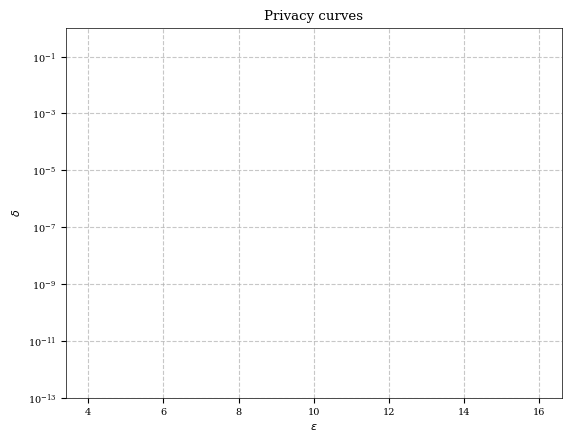

In [97]:

plt.figure()
for eps_value, eps_dict in data.items():
    for por_value, eps_del in eps_dict.items():
        plt.semilogy(eps_del[0], eps_del[1])
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\delta$")
plt.ylim(1e-13, 1) 
plt.title("Privacy curves")
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.show()

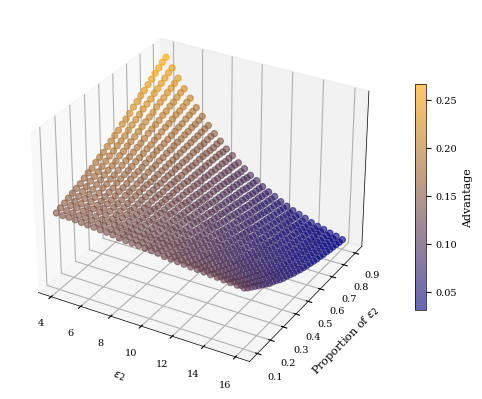

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
import matplotlib as mpl
import matplotlib.colors as mcolors
import cmasher as cmr
mpl.rcParams["text.usetex"] = False  


# Extract data
epsilons, portions, values = [], [], []
for eps, inner in adv_all.items():
    for portion, val in inner.items():
        epsilons.append(float(eps))
        portions.append(float(portion))
        values.append(float(val))

epsilons = np.array(epsilons)
portions = np.array(portions)
values = np.array(values)

# Matplotlib settings for scientific publication
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.linewidth": 0.5,
})

# Create figure sized for double-column (approx 3.5 inches wide)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

# Normalize colors

# Normalize colors
norm = mpl.colors.Normalize(vmin=np.min(values), vmax=np.max(values))

# Custom colormap from blue → orange
cmap = mcolors.LinearSegmentedColormap.from_list("blue_orange", ["navy", "orange"])
# Scatter plot
sc = ax.scatter(
    epsilons, portions, values,
    c=values, cmap=cmap, norm=norm,
    s=20,
    alpha=0.6,  # less transparent (1.0 = fully opaque)
    linewidth=0.8,
    edgecolors="face"  # start with same color as face
)

# Labels with proper subscript
ax.set_xlabel(r'$\epsilon_{2}$', labelpad=4)
ax.set_ylabel(r'Proportion of $\epsilon_{2}$', labelpad=4)

# Remove z-axis
ax.set_zlabel('')
ax.set_zticks([])

# Colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.05)
cbar.set_label("Advantage", fontsize=8)

# Tight layout
plt.tight_layout()
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/3d_plot_adv.png", dpi=300)
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/3d_plot_adv.svg", dpi=300)
plt.show()


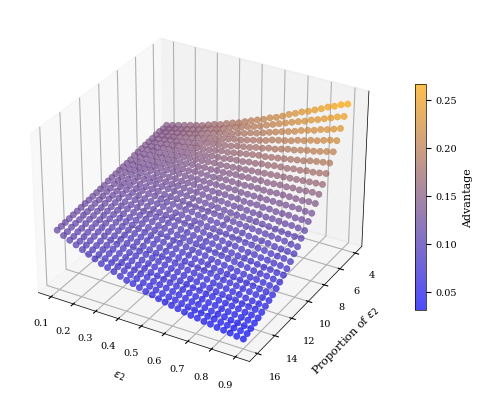

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.rcParams["text.usetex"] = False  


# Extract data
epsilons, portions, values = [], [], []
for eps, inner in adv_all.items():
    for portion, val in inner.items():
        epsilons.append(float(eps))
        portions.append(float(portion))
        values.append(float(val))

epsilons = np.array(epsilons)
portions = np.array(portions)
values = np.array(values)

# Matplotlib settings for scientific publication
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.linewidth": 0.5,
})

# Create figure sized for double-column (approx 3.5 inches wide)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

# Normalize colors

# Normalize colors
norm = mpl.colors.Normalize(vmin=np.min(values), vmax=np.max(values))

# Custom colormap from blue → orange
cmap = mcolors.LinearSegmentedColormap.from_list("blue_orange", ["blue", "orange"])

# Scatter plot
sc = ax.scatter(
    portions, epsilons, values,
    c=values, cmap=cmap, norm=norm,
    s=20,
    alpha=0.7,  # less transparent (1.0 = fully opaque)
    linewidth=0.4,
    edgecolors="face"  # start with same color as face
)
ax.invert_yaxis()
# Labels with proper subscript
ax.set_xlabel(r'$\epsilon_{2}$', labelpad=4)
ax.set_ylabel(r'Proportion of $\epsilon_{2}$', labelpad=4)

# Remove z-axis
ax.set_zlabel('')
ax.set_zticks([])

# Colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.05)
cbar.set_label("Advantage", fontsize=8)

# Tight layout
plt.tight_layout()
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/3d_plot_adv.png", dpi=300)
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/3d_plot_adv.svg", dpi=300)
plt.show()
